### Imports

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette()


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from typing import List, Dict


import time
start_time = time.time()

## חלק ראשון - אקספלורציה

In [3]:
#import train data

df = pd.read_csv("train.csv", index_col= 0)

In [4]:
# נסדר את הפיצ'רים בדאטה לפי סוג הערכים שלהם

def features_lists():

    # numeric feature list
    feature_list_num = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'avlength', 'printables', 'paths', 'urls', 'registry', 'MZ', 'A', 'B']

    #binary feature list
    feature_list_binary = ['has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature']

    #categorical feature list
    feature_list_cat = ['file_type_trid', 'C']

    return  feature_list_num, feature_list_binary, feature_list_cat


In [5]:
feature_list_num, feature_list_binary, feature_list_cat = features_lists()

In [6]:
#utility functions for feature exploration

def feature_exploration(feature_name, data, log=False):
        sns.set_palette(sns.color_palette(['darkcyan', 'plum','royalblue','darkorchid','seagreen','crimson','sandybrown']))  # Set the color palette
        
        #Feature exploration for features with numeric values only
        if feature_name in feature_list_num:
                fig, axs = plt.subplots(1, 3, figsize=(20, 5))

                # Plot 1: Distribution of the feature (Histogram)
                axs[0].hist(data[feature_name])
                axs[0].set_xlabel(f'{feature_name}')
                axs[0].set_title(f'Distribution of {feature_name}')
                if log == True:
                        axs[0].set_yscale('log')
                        axs[0].set_ylabel('Frequency (log)')
                else:
                        axs[0].set_ylabel('Frequency')
                        

                # Plot 2: Scatter plot of the feature by label
                data_sampled = data.sample(n=500) #sample of the data
                scatter = sns.scatterplot(x=data_sampled.index, y=feature_name, hue=data_sampled['label'], data=data_sampled, ax=axs[1])
                axs[1].set_ylabel(f'{feature_name}')
                axs[1].set_title(f'Scatter plot of {feature_name} by Label')
                axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)                
                label_names = {0: 'Not Malicious', 1: 'Malicious'}
                legend_colors = ['darkcyan', 'plum']
                scatter.legend(labels=list(label_names.values()), loc='upper left')
                for handle, color in zip(scatter.legend_.legendHandles, legend_colors):
                        handle.set_color(color)


                # Plot 3: Density plot of the feature by label
                subset_data = data[data[feature_name].notnull()]
                ax = axs[2]
                for label in subset_data['label'].unique():
                        sns.kdeplot(subset_data.loc[subset_data['label'] == label, feature_name], label=label, shade=True, ax=ax)
                        ax.set_xlabel(feature_name)
                        ax.set_ylabel('Density')
                        ax.set_title(f'Density Plot of {feature_name} by Label')
                        label_names = {'0': 'Not Malicious', '1': 'Malicious'}
                        legend_colors = ['darkcyan', 'plum']
                        plt.legend(labels=label_names, labelcolor=legend_colors)
                        ax.legend(['Not Malicious', 'Malicious'])
                
                plt.subplots_adjust(wspace=0.3)

                plt.show()


        #Feature exploration for features with binary values only
        if feature_name in feature_list_binary:
                fig, axs = plt.subplots(1, 2, figsize=(15, 5))

                # Plot 1: bar plot of feature distribution
                num_unique = data[feature_name].nunique()
                data[feature_name].value_counts().plot.barh(ax=axs[0])
                axs[0].set_xlabel('Frequency')
                axs[0].set_ylabel(f'{feature_name}')
                axs[0].set_title(f'Distribution of {feature_name}')

                # Plot 2: Label rate for each unique value
                counts = data.groupby([data['label'], data[feature_name]]).size().unstack()
                ax = counts.plot(kind='bar', stacked=False, ax=axs[1])
                ax.legend()

                # Add count values inside each bar
                for i, patch in enumerate(ax.patches):
                        count = patch.get_height()
                        x = patch.get_x() + patch.get_width() / 2
                        y = patch.get_y() + patch.get_height() / 2
                        ax.text(x, y, count, ha='center', va='center', rotation=90)

                axs[1].set_xlabel('Label')
                axs[1].set_xticklabels(['Not Malicious', 'Malicious'], rotation=0)
                axs[1].set_ylabel('Count')
                axs[1].set_title(f'Distribution of {feature_name} by Label')

                # Adjust spacing between subplots
                plt.subplots_adjust(wspace=0.3)

                # Show the plots
                plt.show()

                
                
        #Feature exploration for features with categorical values only
        if feature_name in feature_list_cat:

                #plot the distribution of the 10 most common unique values of the feature
                num_unique = data[feature_name].nunique()
                data[feature_name].value_counts().head(10).plot.barh()
                plt.xlabel('Frequency')
                plt.ylabel(f'{feature_name}')
                plt.title(f'Distribution of {feature_name}')
                

                #plot the label rate for each of the feature unique values
                if num_unique < 15:
                        counts = data.groupby([data['label'], data[feature_name]]).size().unstack()
                        ax = counts.plot(kind='bar', stacked=False)
                        ax.legend()

                        # Add count values inside each bar
                        for i, patch in enumerate(ax.patches):
                                count = patch.get_height()
                                x = patch.get_x() + patch.get_width() / 2
                                y = patch.get_y() + patch.get_height() / 2
                                ax.text(x, y, count, ha='center', va='center', rotation=90)

                        plt.xlabel('Label')
                        ax.set_xticklabels(['Not Malicious', 'Malicious'],rotation=0)
                        plt.ylabel('Count')
                        plt.title(f'Distribution of {feature_name} by Label')

                # Show the plots
                plt.show()
                
# Correlation heatmap                
def correlation(data):
        sns.heatmap(data.corr(), xticklabels=data.corr().columns,
        yticklabels=data.corr().columns)
        

## אקספלורציה

נבדוק כמה ערכים יש מכל לייבל

In [7]:
df['label'].value_counts()

0    30000
1    30000
Name: label, dtype: int64

ניתן לראות כי הלייבל מתפלג בצורה שוויונית לאורך הנתונים. כלומר, כמות הקבצים הזדוניים והלא זדוניים שווה.

### פיצ'רים מספריים

עבור כל פיצ'ר מספרי, נראה 3 גרפים שיעזרו לקבל מידע על הפיצ'ר
1. היסטוגרמה של ערכי הפיצ'ר (log)
2. פיזור ערכי הפיצ'ר לפי חלוקה של הלייבלים (500 תצפיות)
3. התפלגות של ערכי הפיצ'ר לפי חלוקה של הלייבלים

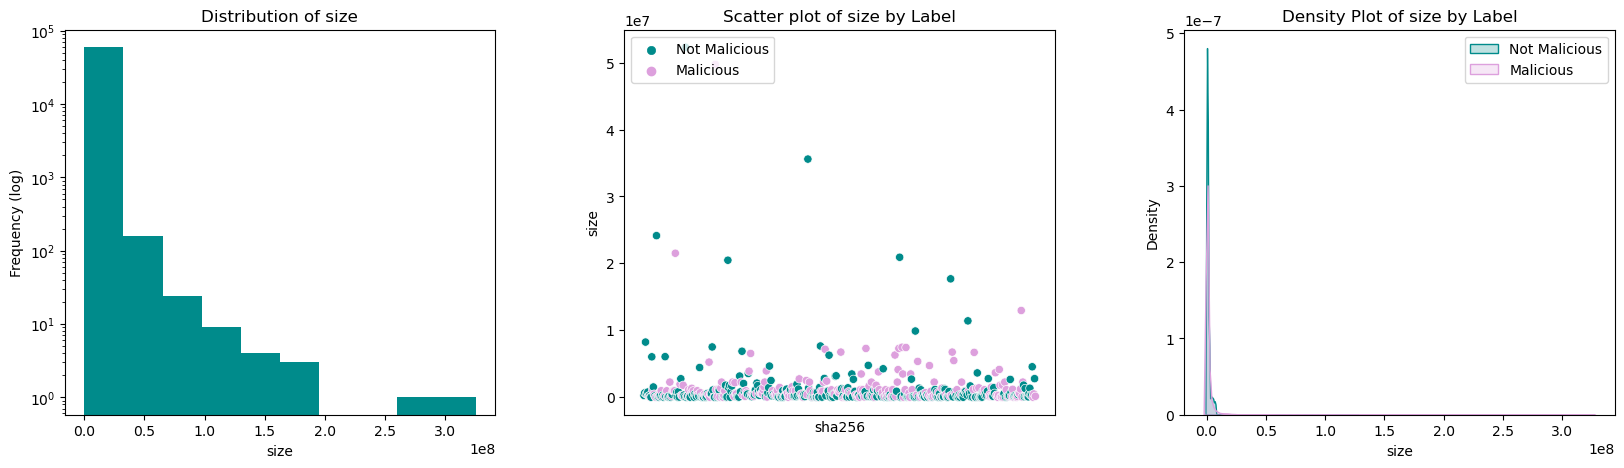

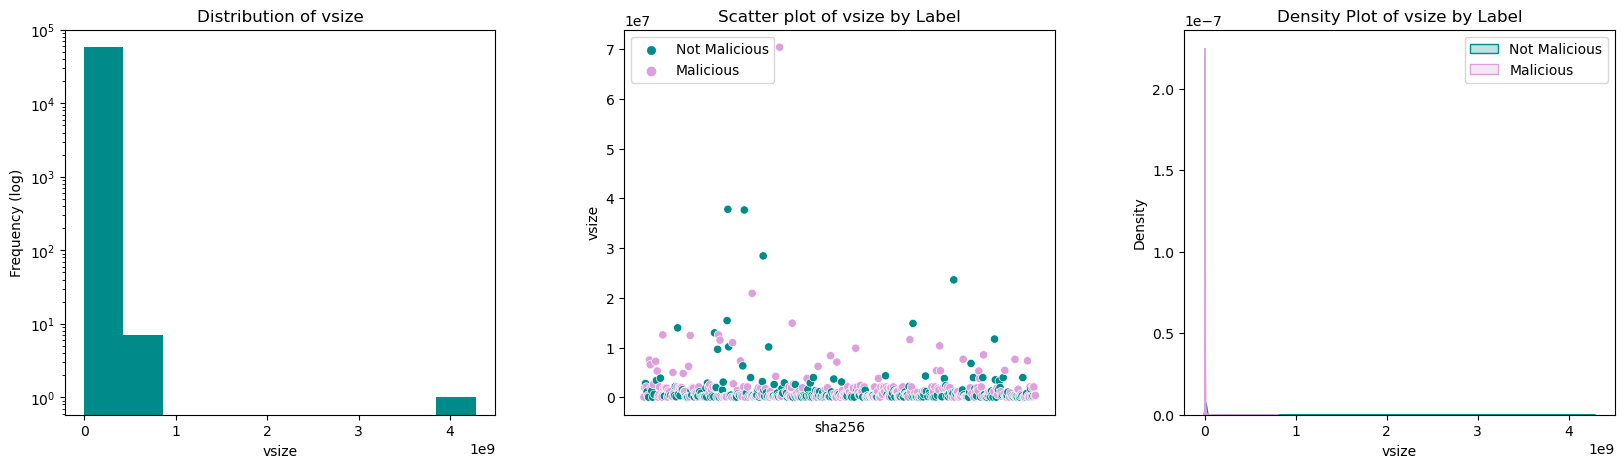

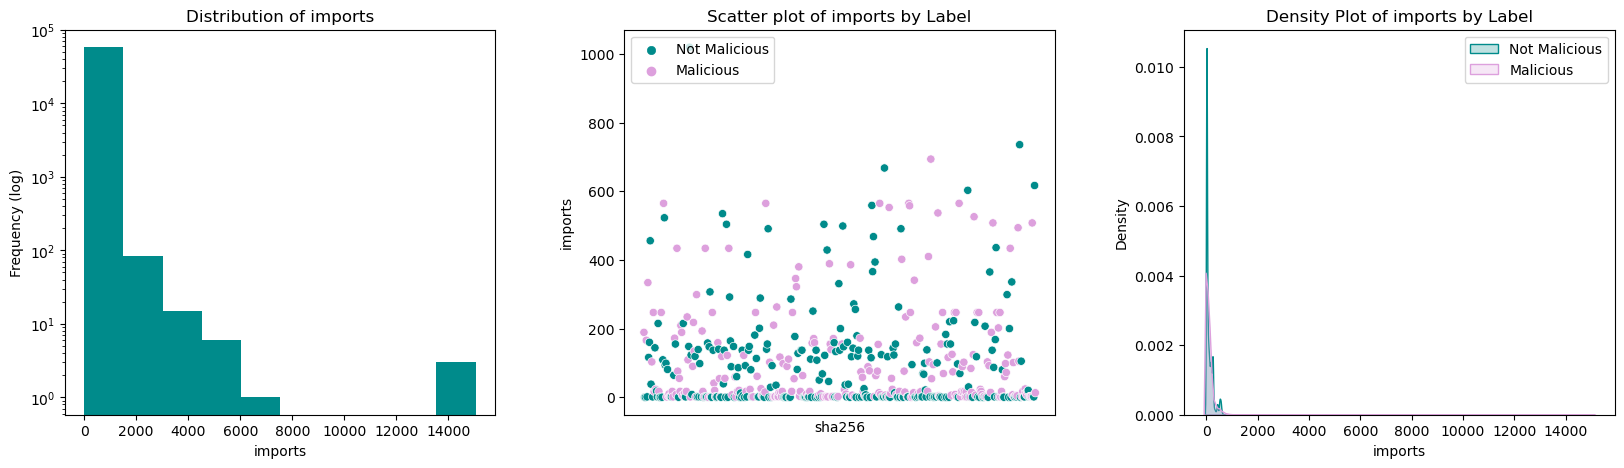

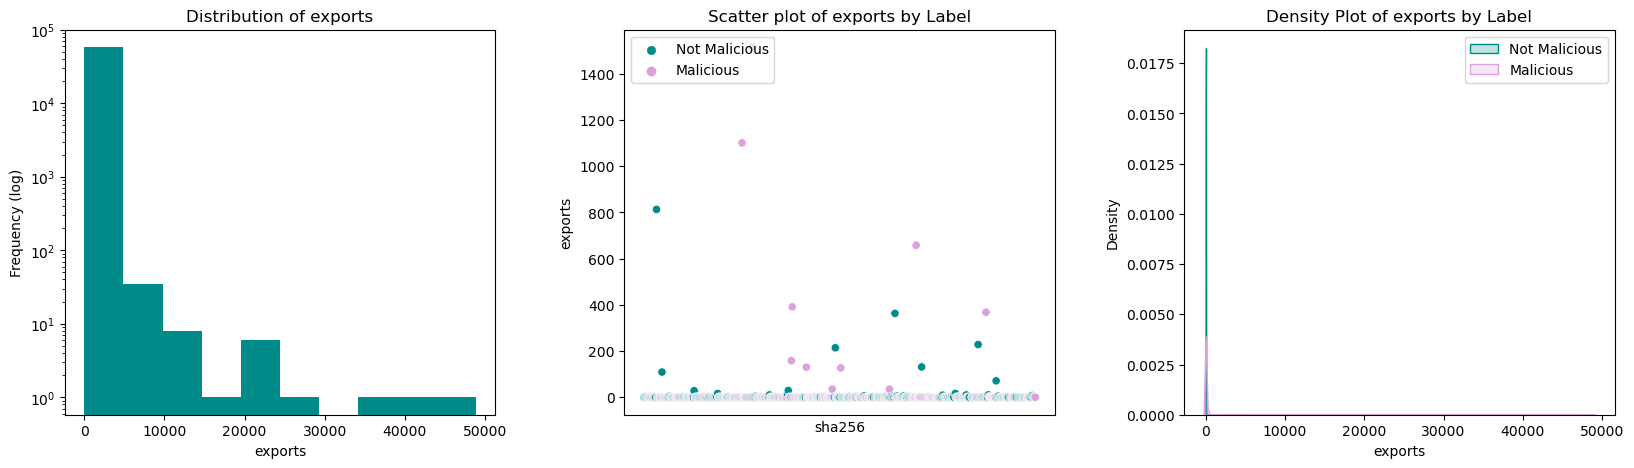

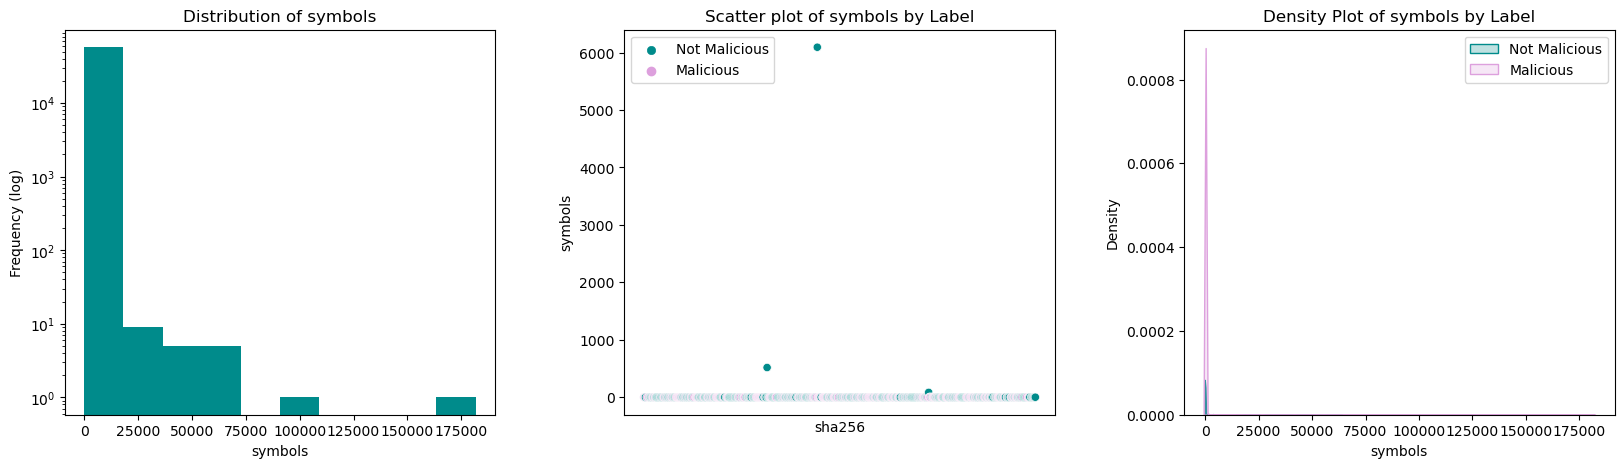

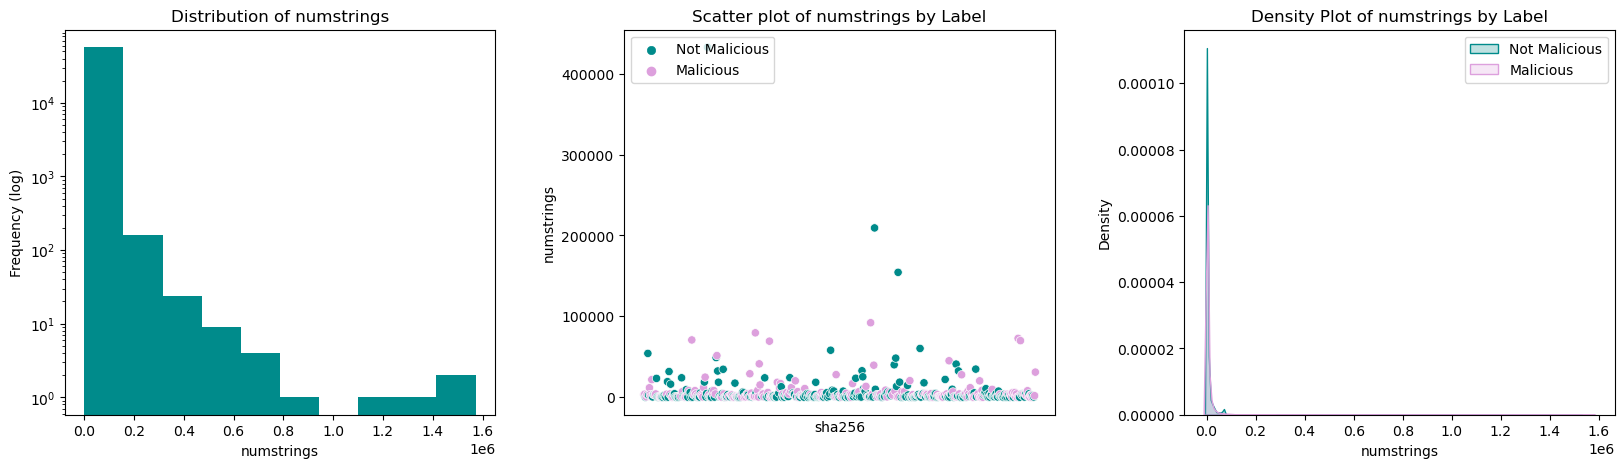

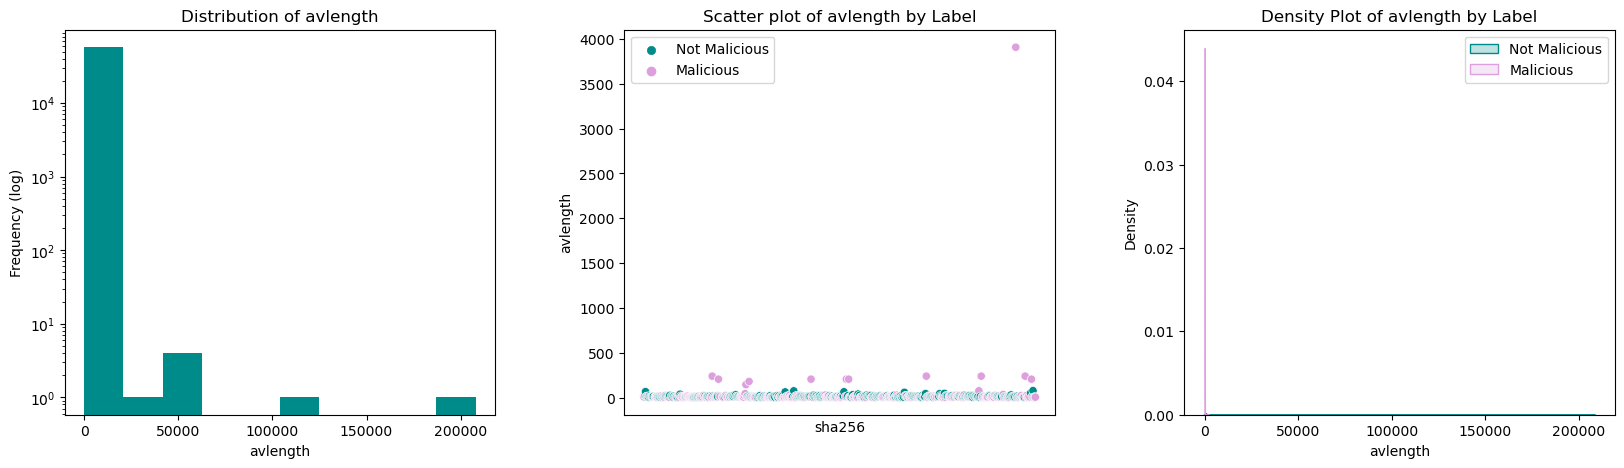

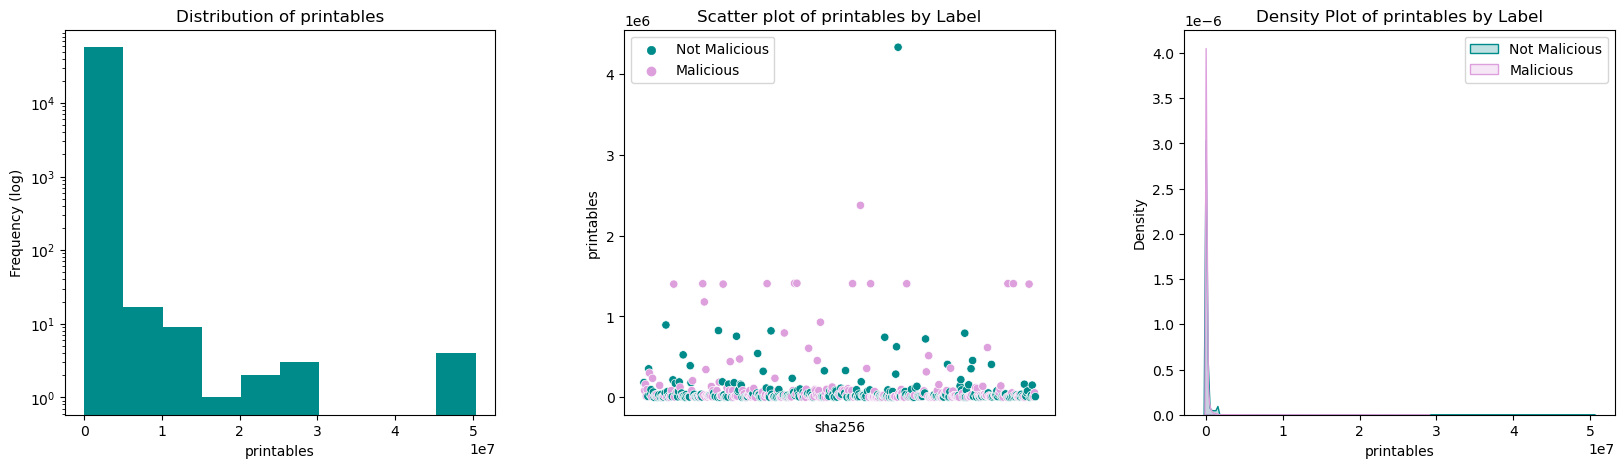

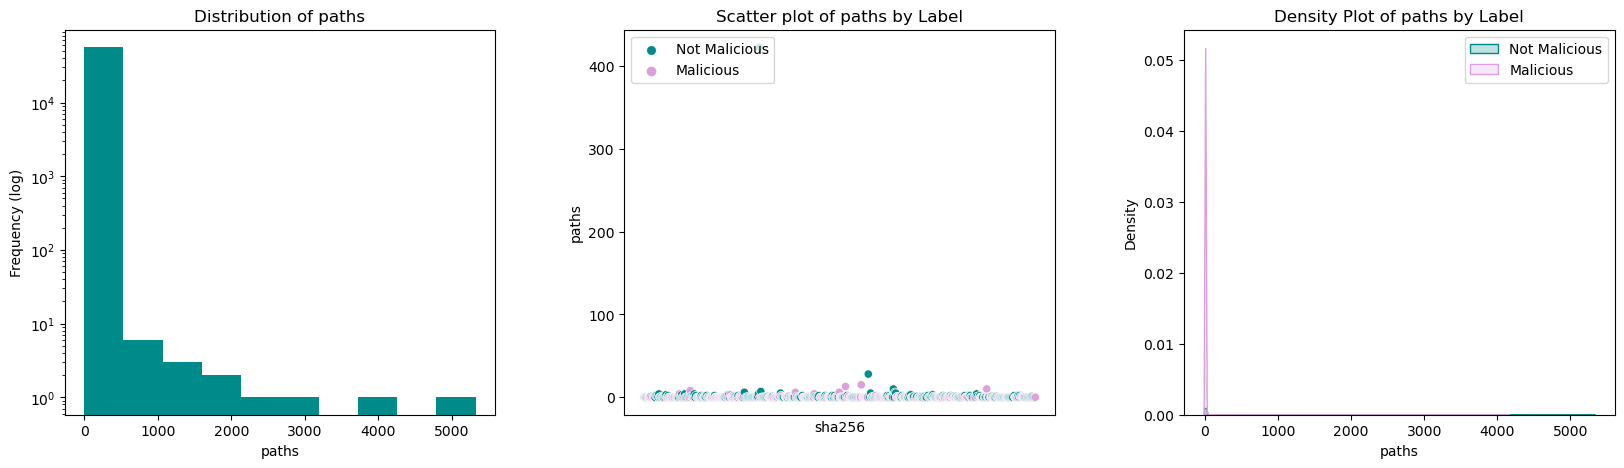

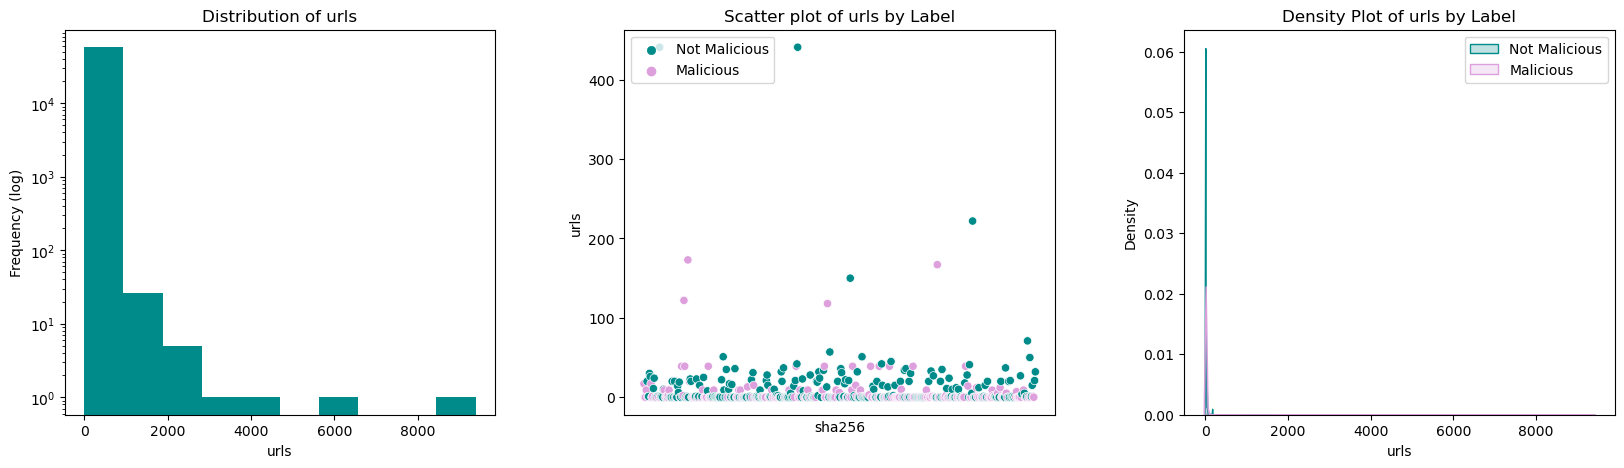

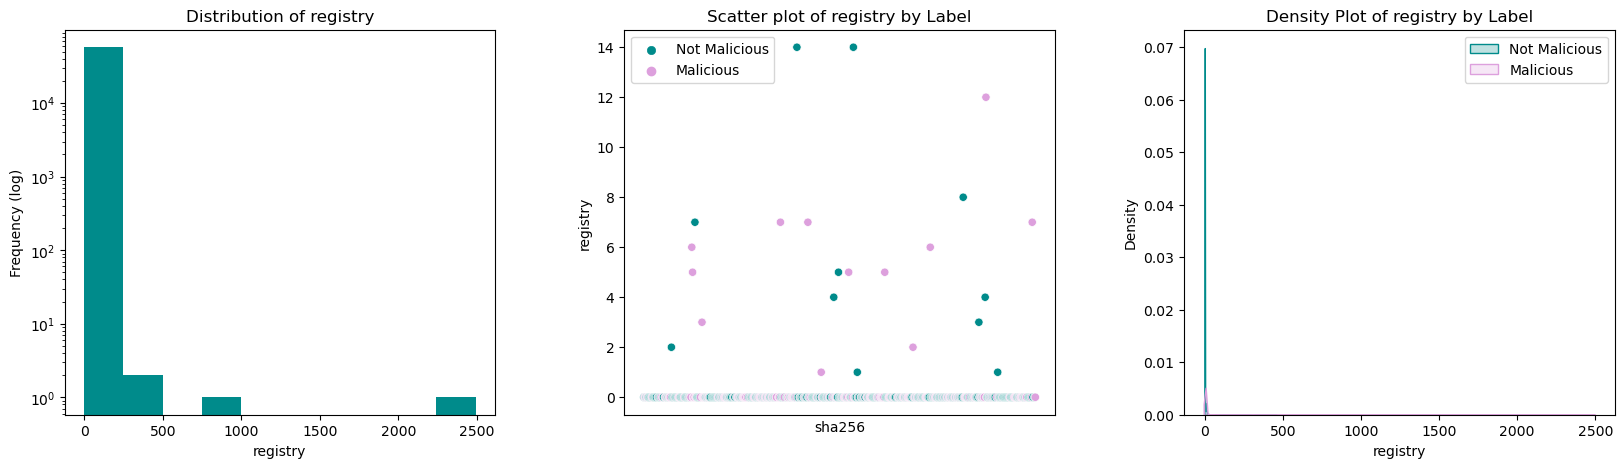

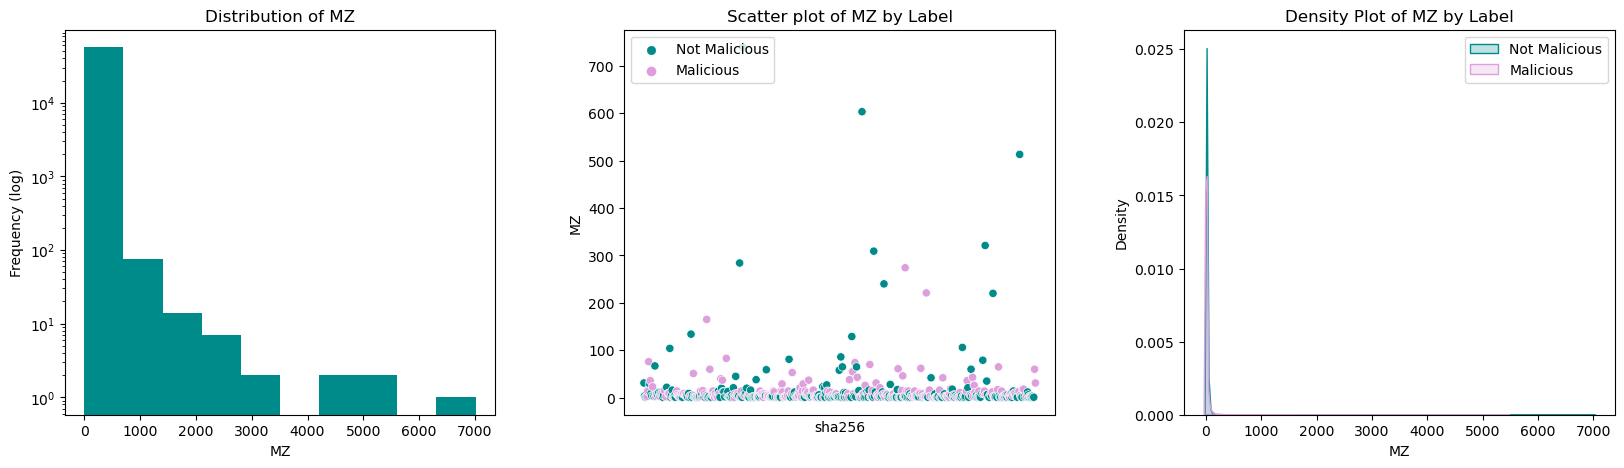

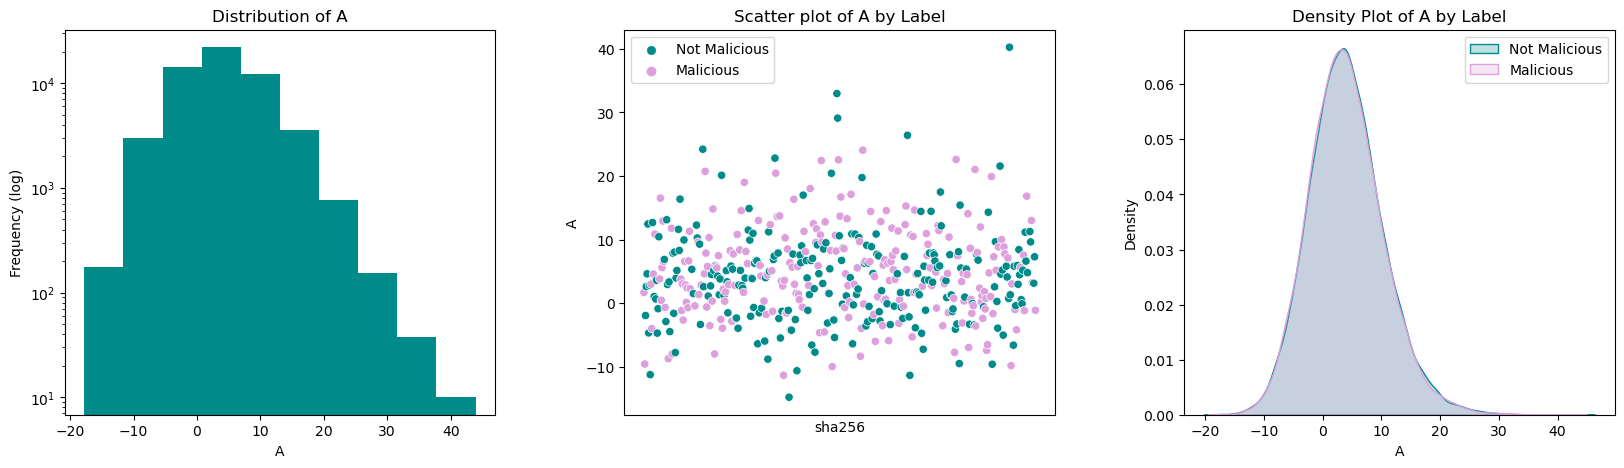

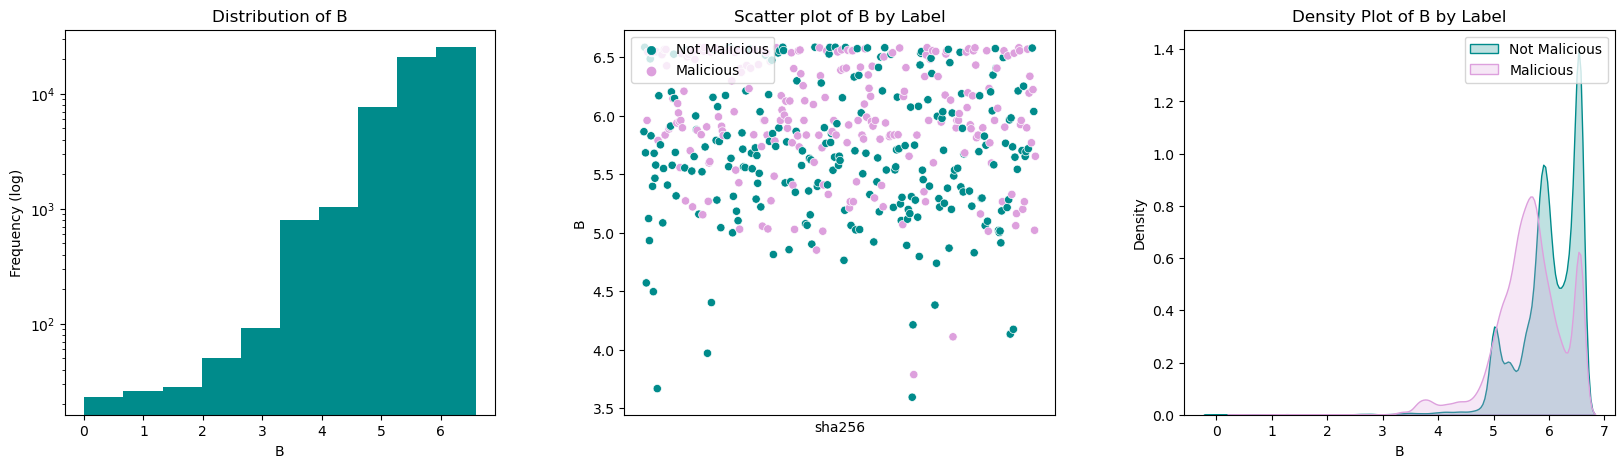

In [8]:
#numeric features
for feature in feature_list_num:
    feature_exploration(feature,df,True)


ניכר כי רוב הפיצ'רים מתפלגים בהתפלגות המזכירה powerlaw
זוהי התפלגות אקספוננציאלית שלילית, כלומר עיקר צפיפות הנתונים נמצאת בערכים הקטנים.

בנוסף, ההתפלגות של המשתנה A, בחלוקה לליבל הינה שווה.
כלומר, לא נראה שערך מסוים של A משפיע על הלייבל.

לגבי פיצ'ר B, נראה כי מתפלג בצורה אקספוננציאלית. הפוך מpowerlaw

### פיצ'רים קטגוריאליים

עבור כל פיצ'ר קטגוריאלי, נראה 2 גרפים שיעזרו לקבל מידע על הפיצ'ר
1. התפלגות של עשרת הערכים הכי נפוצים בפיצ'ר
2. עבור פיצ'ר שיש לו פחות מ15 ערכים חד-חד ערכיים, נראה גם עבור כל ערך של הפיצ'ר את ההתפלגות שלו מבחינת לייבלים

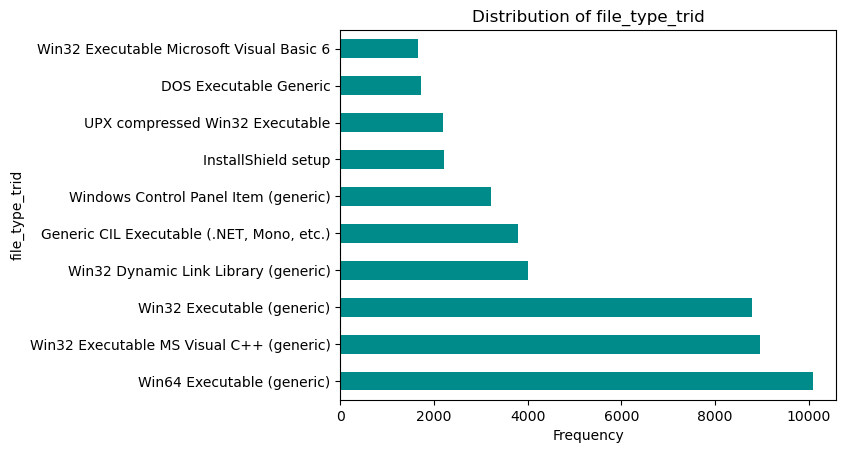

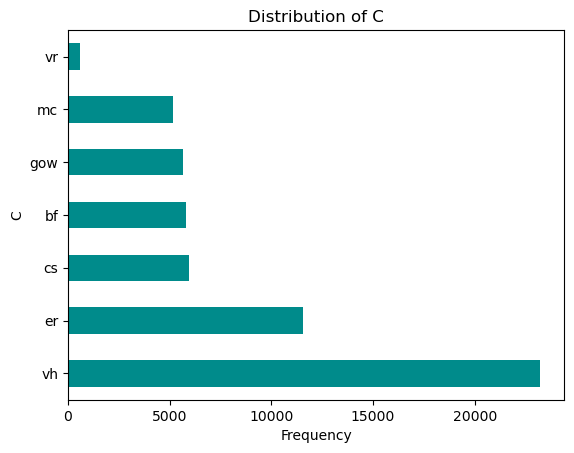

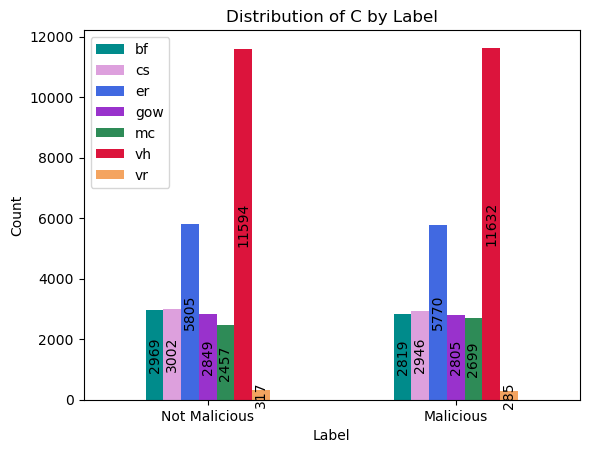

In [9]:
#categorical features

for feature in feature_list_cat:
    feature_exploration(feature,df)

file type trid - נראה כי רוב המוחלט של הערכים בדאטהסט של האימון שייכים לסוג Win

C - ניתן לראות כי עבור כל ערך חד-חד ערכי בפיצ'ר זה יש התפלגות דומה עד כדי זהה בין הלייבלים

### פיצ'רים בינאריים

עבור כל פיצ'ר בינארי, נראה 2 גרפים שיעזרו לקבל מידע על הפיצ'ר
1. התפלגות של ערכי הפיצ'ר
2. התפלגות של ערכי הפיצ'ר לפי הלייבל

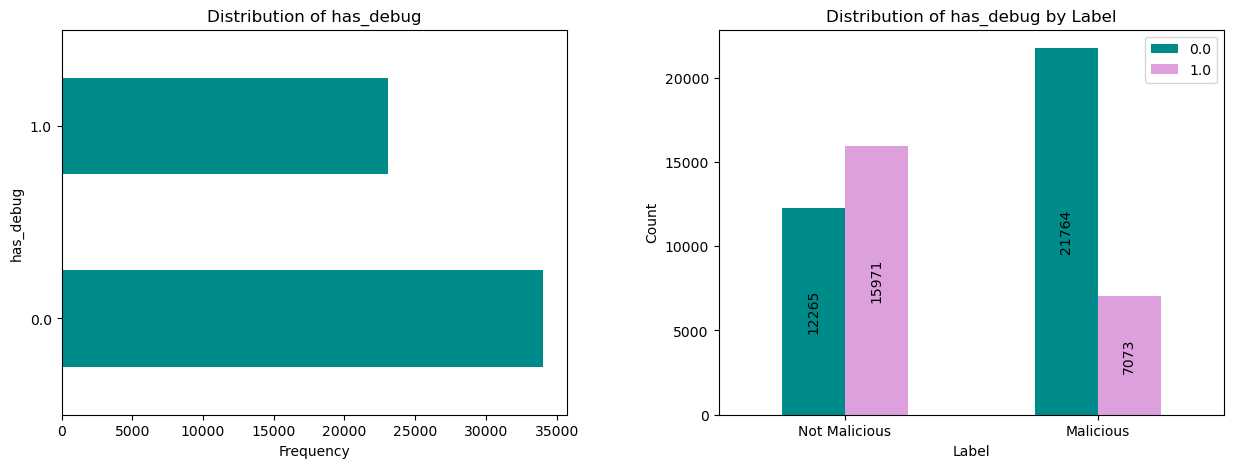

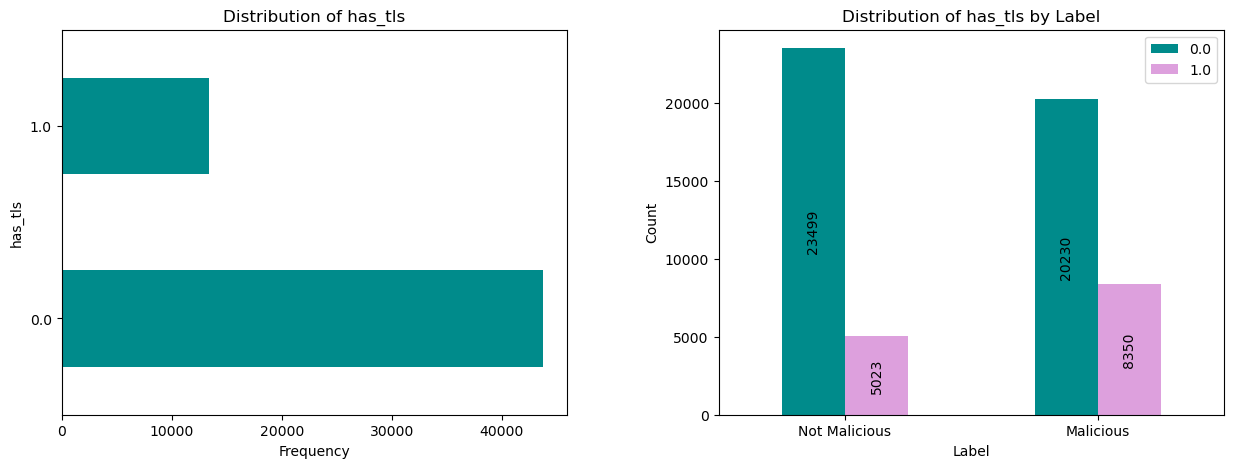

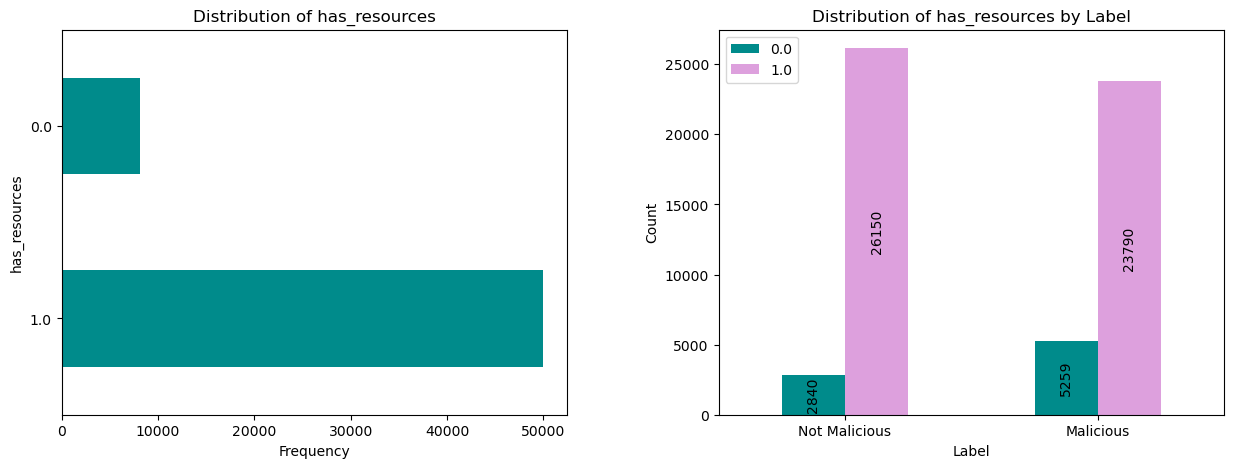

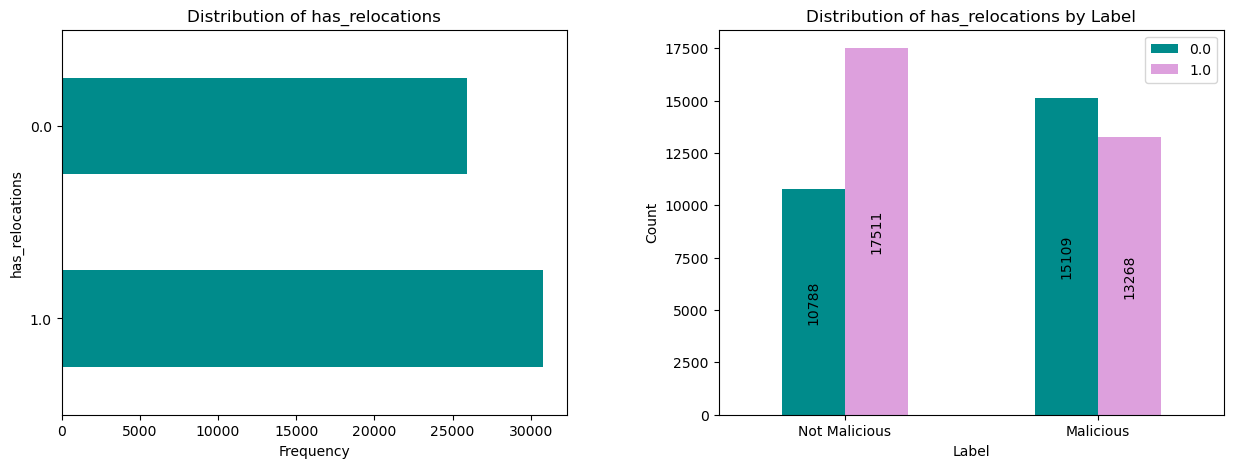

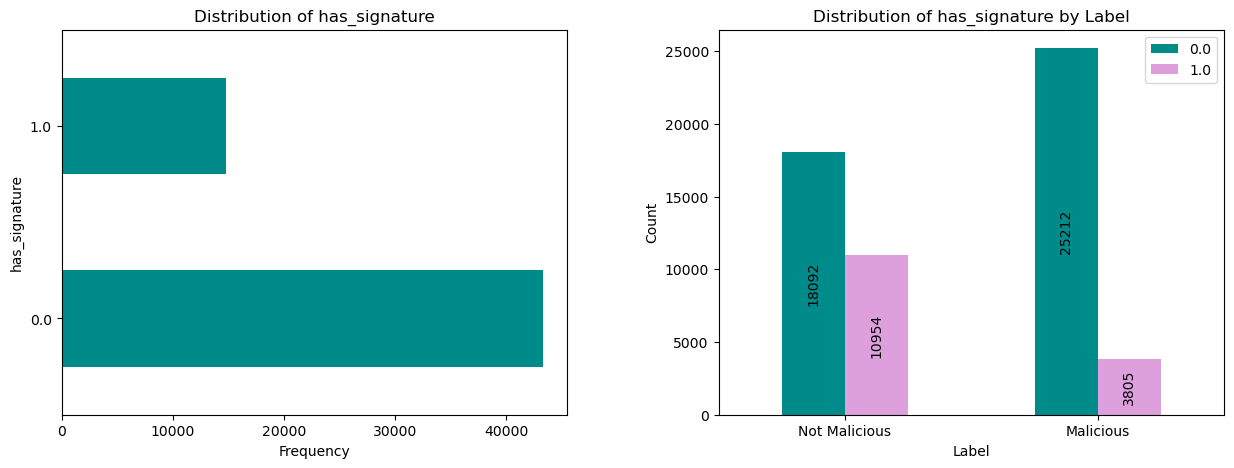

In [10]:
#Binary features

for feature in feature_list_binary:
    feature_exploration(feature,df,df['label'])

מהגרפים הנ"ל עולים כמה נתונים מעניינים:

1. has_debug -
הערך הנפוץ ביותר הוא has_debug = 0
נראה כי עבור has_debug = 0, יש את הסבירות הגבוהה ביותר לקבל קובץ זדוני
הדבר תואם למידע שמצאנו באינטרנט: has_debug: Malicious files may try to hide their presence by excluding debug information.  

2. has_tls - 
הערך הנפוץ ביותר (משמעותית) הוא has_tls = 0
נראה כי עבור has_tls = 1, יש את הסבירות הגבוהה ביותר לקבל קובץ זדוני
הדבר תואם למידע שמצאנו באינטרנט: has_tls: Malware may use thread local storage (TLS) for various malicious purposes, such as code injection or data encryption. 

3. has_resources - 
הערך הנפוץ ביותר (משמעותית) הוא has_resources = 1
נראה כי עבור has_resources = 0, יש את הסבירות הגבוהה ביותר לקבל קובץ זדוני

4. has_relocation - 
הערך הנפוץ ביותר הוא has_relocation = 1
נראה כי עבור has_relocation = 0, יש את סבירות הגבוהה ביותר לקבל קובץ זדוני

5. has_signature - 
הערך הנפוץ ביותר (משמעותית) הוא has_signature = 0
נראה כי עבור has_signature = 0, יש את הסבירות הגבוהה ביותר לקבל קובץ זדוני
הדבר תואם למידע שמצאנו באינטרנט: Legitimate files are more likely to have digital signatures, whereas the absence of a signature can raise suspicion in terms of file integrity and authenticity.


### קורלציה

נבחן קורלציה בין הפיצ'רים השונים ובין הפיצ'רים ללייבל

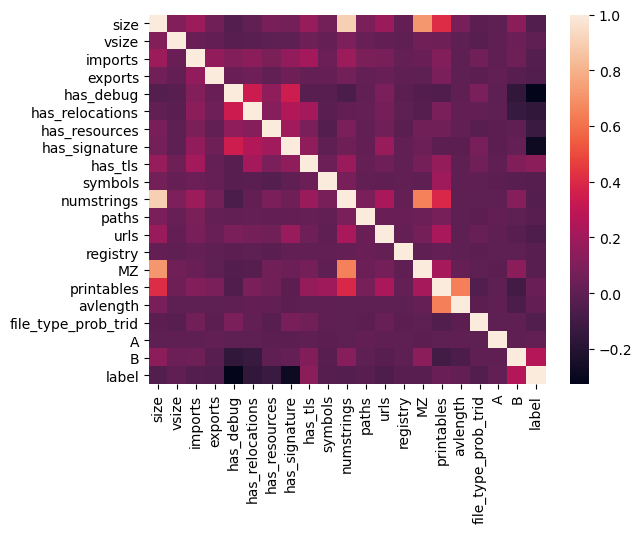

In [11]:
correlation(df)

ממטריצת הקורלציות עולות מספר קורלציות מעניינות:
1. קורלציה חיובית חזקה בין size, numstrings and MZ.
2. קורלציה חיובית בין printables and avlength.
3. קורלציה שלילית חזקה בין פיצ'ר has_debug לבין הלייבל
4. קורלציה שלילית חזקה בין פיצ'ר has_signature לבין הלייבל


חלק מהקורלציות הנ"ל מקבלות ביסוס נוסף ממידע שמצאנו באתרים שונים:
1. has_debug: Malicious files may try to hide their presence by excluding debug information. 
2. has_signature: Legitimate files are more likely to have digital signatures, whereas the absence of a signature can raise suspicion in terms of file integrity and authenticity.

### ערכים חסרים

B                      3751
A                      3704
paths                  3660
has_relocations        3324
MZ                     3089
has_debug              2927
has_tls                2898
avlength               2757
printables             2739
numstrings             2718
symbols                2656
registry               2525
urls                   2349
exports                2093
C                      2051
has_resources          1961
has_signature          1937
vsize                  1935
imports                1739
size                      0
file_type_prob_trid       0
file_type_trid            0
label                     0
dtype: int64

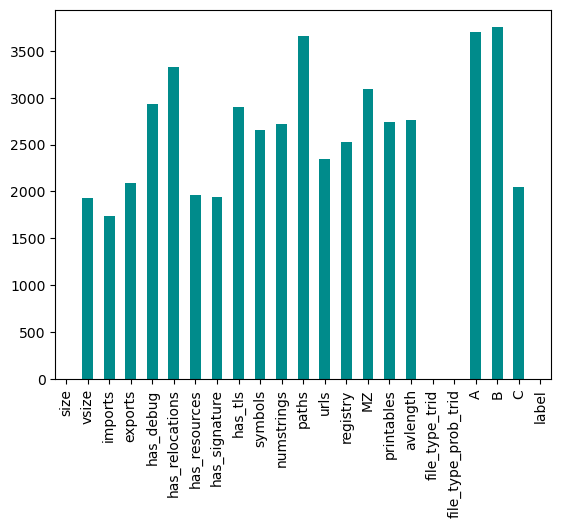

In [12]:
#כמה ערכים חסרים יש עבור כל פיצ'ר
df.isnull().sum().plot.bar(rot=90,color='darkcyan')
df.isnull().sum().sort_values(ascending=False)

בחלק של עיבוד מקדים נטפל בערכים החסרים של הפיצ'רים הנ"ל

In [13]:
#בנוסף, נבדוק האם יש סמפלים שיש להם מספר גבוה של ערכים חסרים (במידה וכן ייתכן ונסיר אותם סמפלים)

empty_values = df.isna().sum(axis=1).sort_values(ascending=False).head(10)
empty_values.reset_index(drop=True)

0    7
1    6
2    6
3    6
4    6
5    6
6    6
7    6
8    6
9    6
dtype: int64

עולה כי לא קיימות תצפיות רבות להן שיעור ערכים חסרים גבוה, למעשה המספר המירבי של ערכים חסרים המקסימלי הוא 7 (מתוך 23 ערכים).
מכיוון שמדובר במספר קטן יחסית, החלטנו לא להסיר תצפיות.

## עיבוד מקדים

### ערכים חסרים

תחילה נשלים ערכים חסרים עבור פיצ'רים עם ערכים בינאריים.
עבור פיצ'רים אלו קודם כל נבדוק מה הוא הערך הנפוץ יותר בפיצ'ר ולאחר מכן נמלא את כל החסרים הריקים של אותו פיצר עם ערך זה.

בפונקציות הבאות נשתמש בשתי השמות:

data_aggregation_based - על בסיס איזה דאטה עשינו את האגרגציה

data_aggregaion_apply - על איזה דאטה נרצה להכיל את האגרגרציה

In [14]:
#features with binary values

def empty_values_binary(data_based,data_applied,feature_binary):
    for feature in feature_binary:
        common = data_based[feature].mean() #find the most common value of the feature
        data_applied[feature].fillna(round(common), inplace=True) #fill empty values with the common value

In [15]:
empty_values_binary(df,df,feature_list_binary)

נשלים ערכים חסרים עבור פיצ'רים עם ערכים מספריים.
קודם נמצא עבור כל פיצ'ר את הערך החציוני ולאחר מכן נמלא את כל הערכים הריקים של אותו פיצר עם הערך החציוני שמצאנו.

In [16]:
#features with numeric values
def empty_values_numeric(data_based,data_applied, feature_num):
    for feature in feature_num:
        median = data_based[feature].median() #find the median value of the feature
        data_applied[feature].fillna(median, inplace=True) #fill empty values with the median value


In [17]:
empty_values_numeric(df,df, feature_list_num)

### הוספת פיצ'רים חדשים

רוב הפיצ'רים המספריים מתפלגים בצורה של powerlaw.
מהאקספלורציה הראשונית שביצענו ראינו כי כאשר אנחנו מציגים את אותם פיצ'רים בlog(x+1), ההתפלגות נראית טוב יותר ולעיתים אף נורמלית.
ולכן רצינו לקחת את אותם פיצ'רים, לעשות להם מניפולציה מתמטית של לוג ולהוסיף אותם כפיצ'רים חדשים.

In [18]:
def add_feature_logs(data, feature_list_num):
    log_feature_list = []
    transformed_data = data.copy()
    for feature in feature_list_num:
        if (feature == 'A' or feature == 'B'): #exclude numeric features that shouldn't het log manipulation (based on the exploration phase)
            continue   
        if feature =='log_size':
            break
        transformed_data['log_' + feature] = np.log(data[feature] + 1)
        log_feature_list.append('log_' + feature)
        transformed_data = transformed_data.filter(regex='^log_')
    data = pd.concat([data, transformed_data], axis=1)
    for feature in log_feature_list:
        feature_list_num.append(feature)
    return data, feature_list_num, log_feature_list

In [19]:
df, feature_list_num, log_feature_list = add_feature_logs(df, feature_list_num)

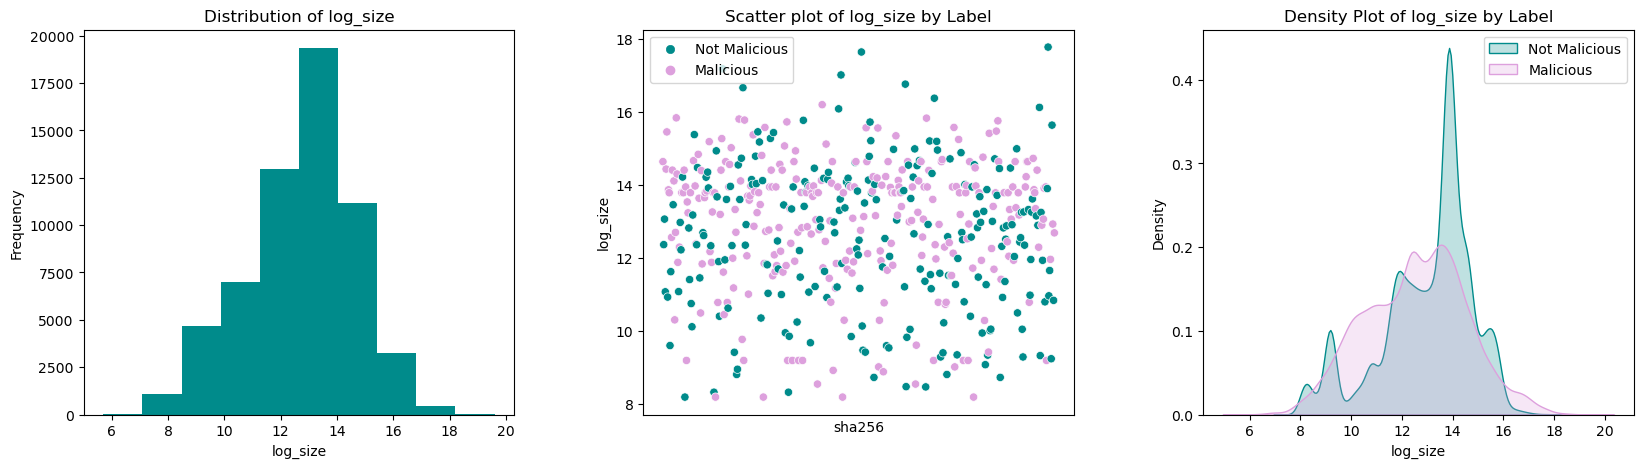

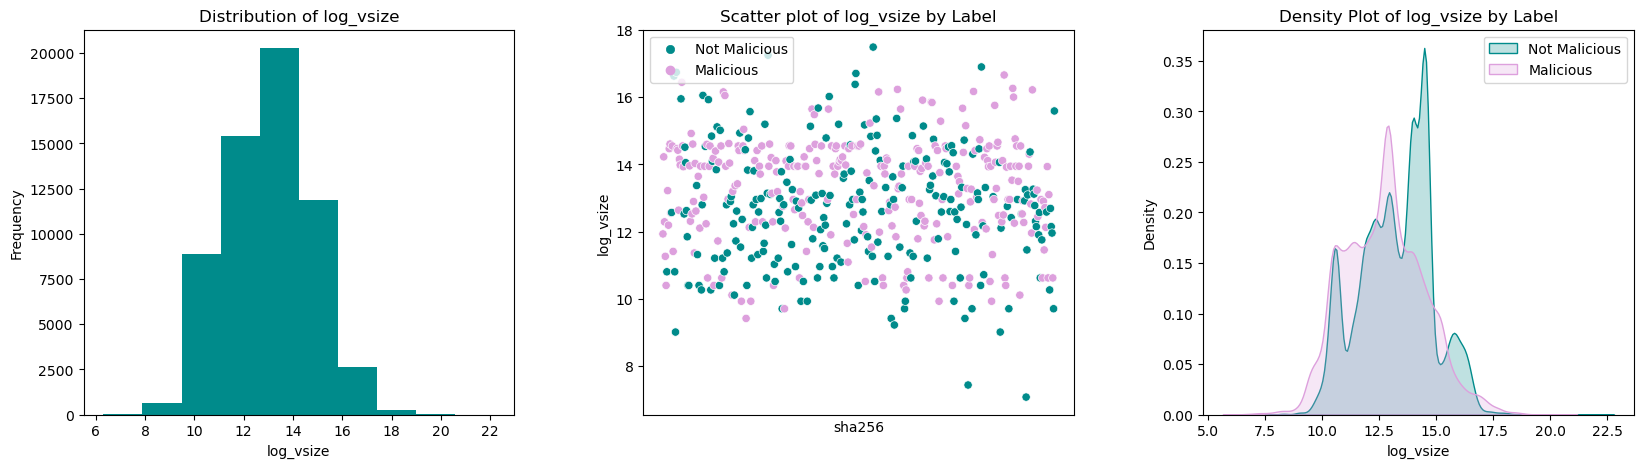

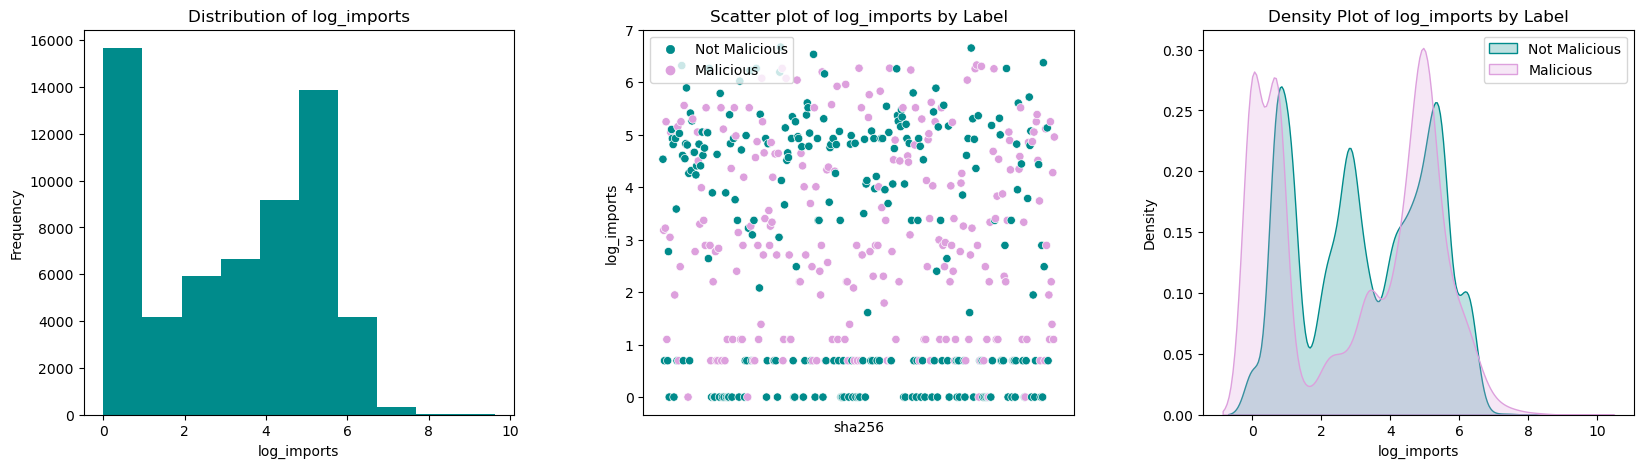

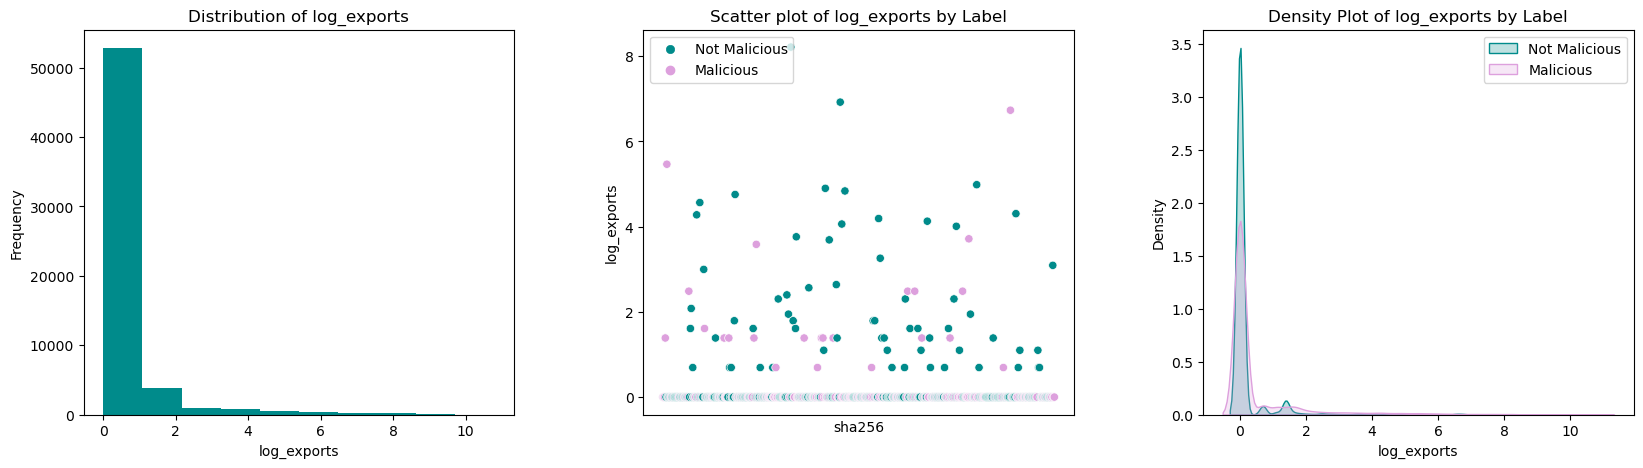

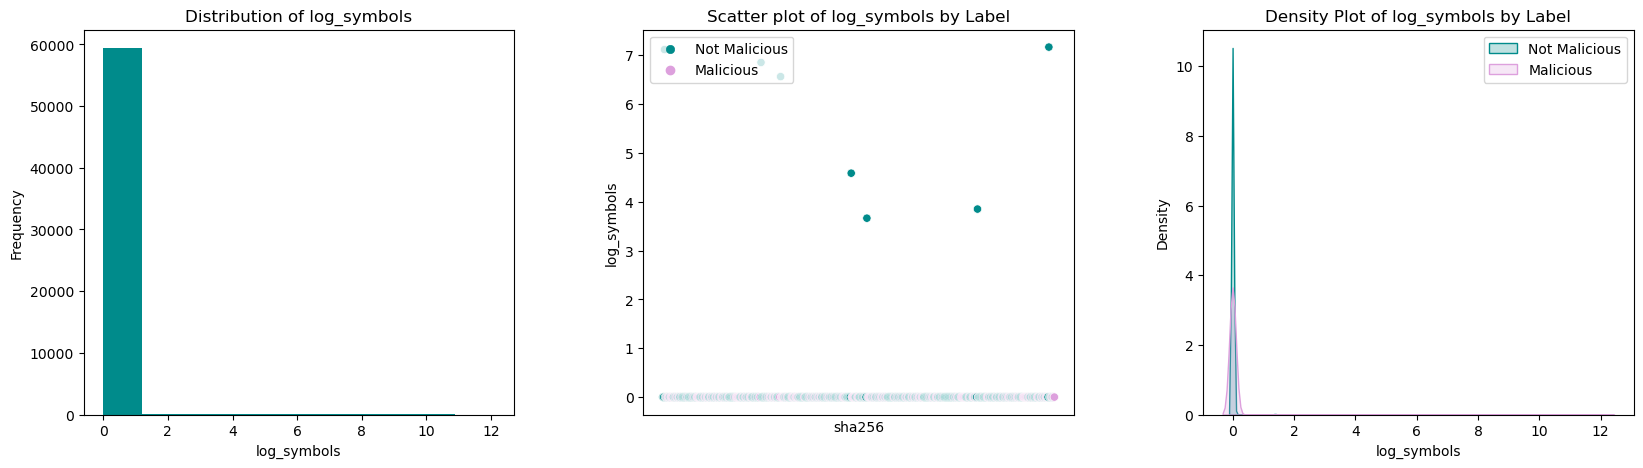

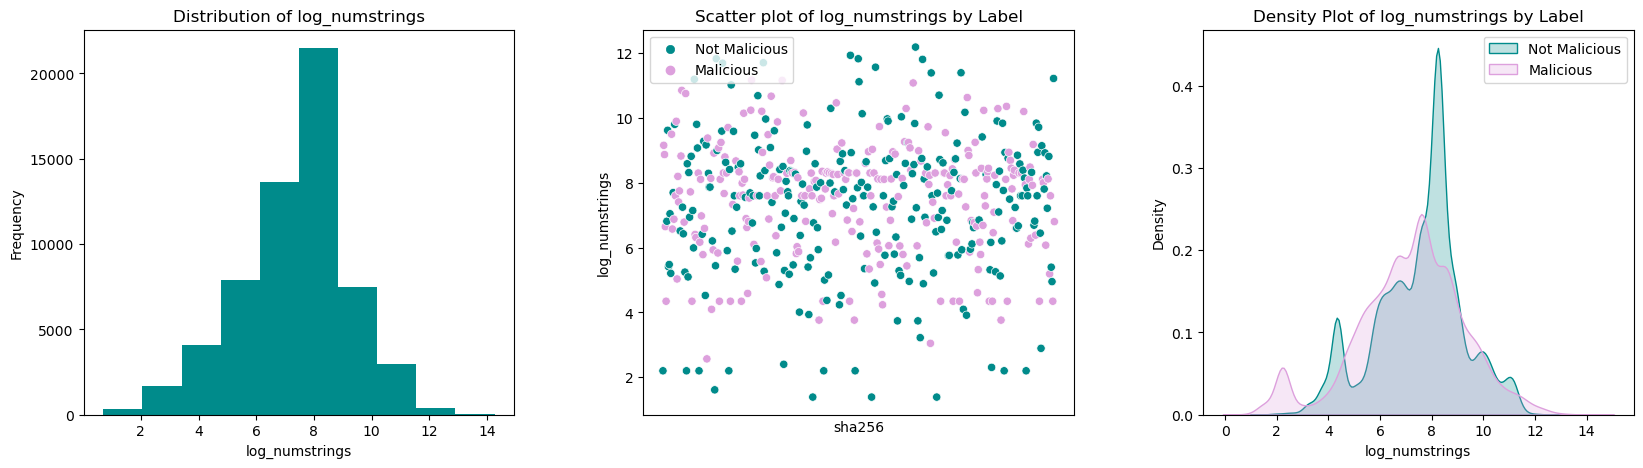

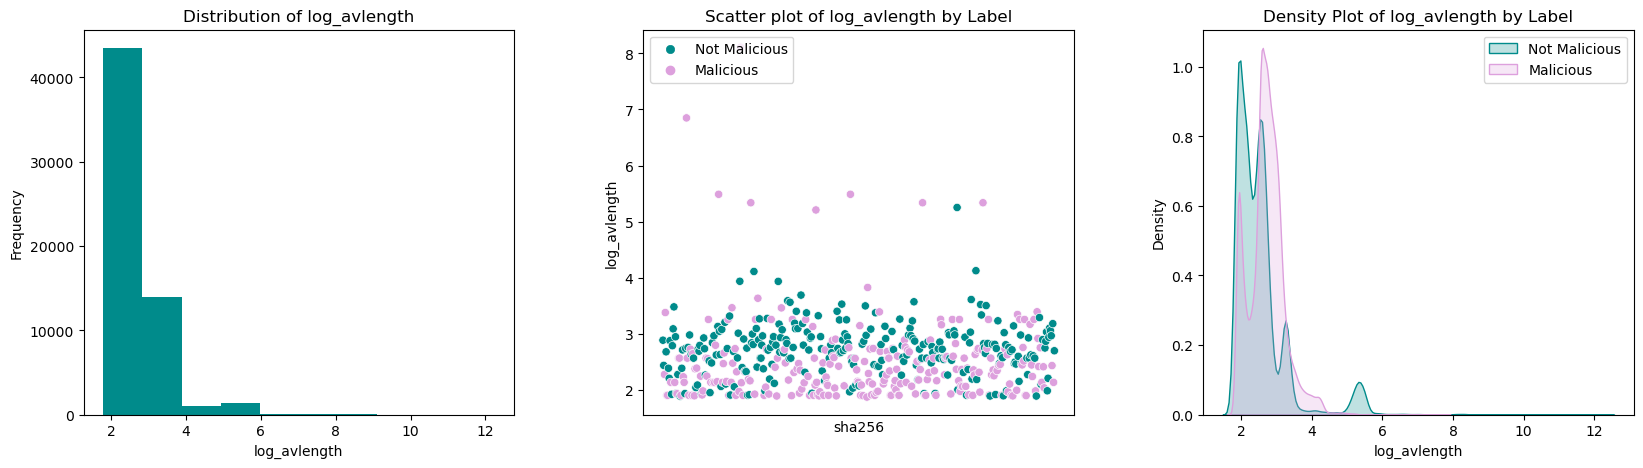

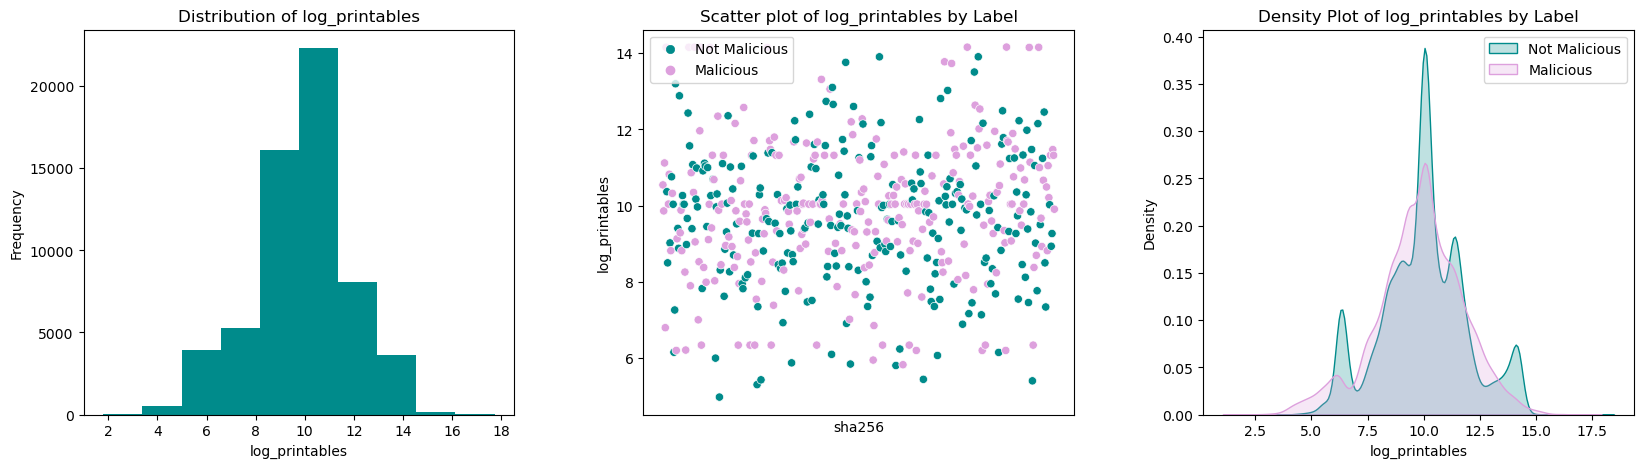

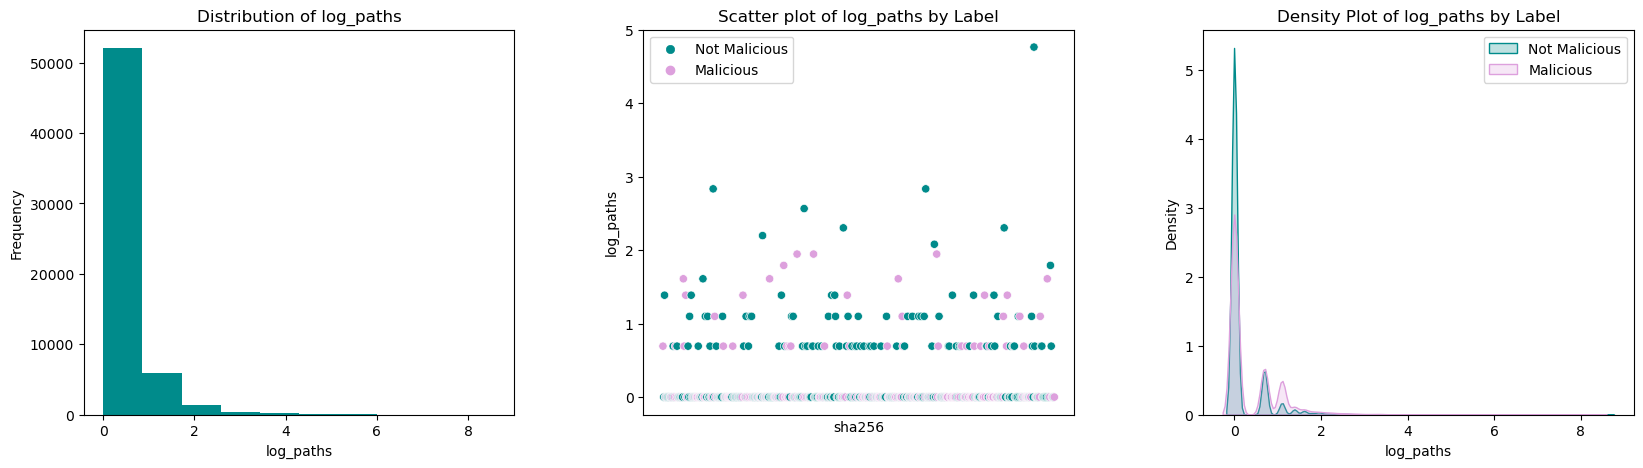

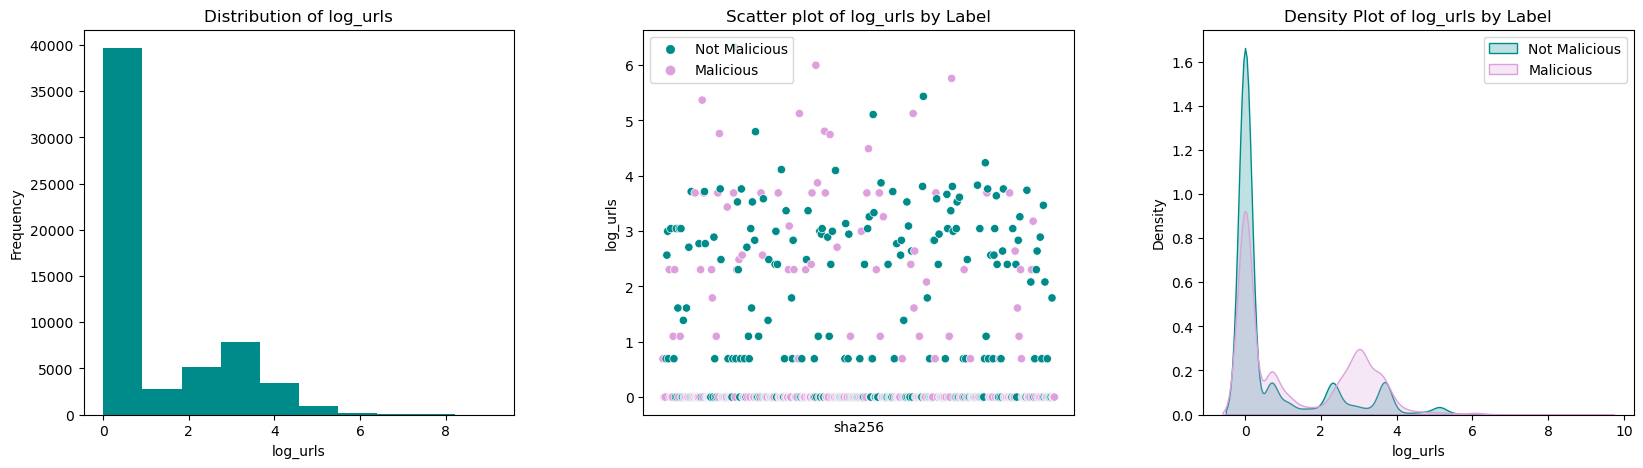

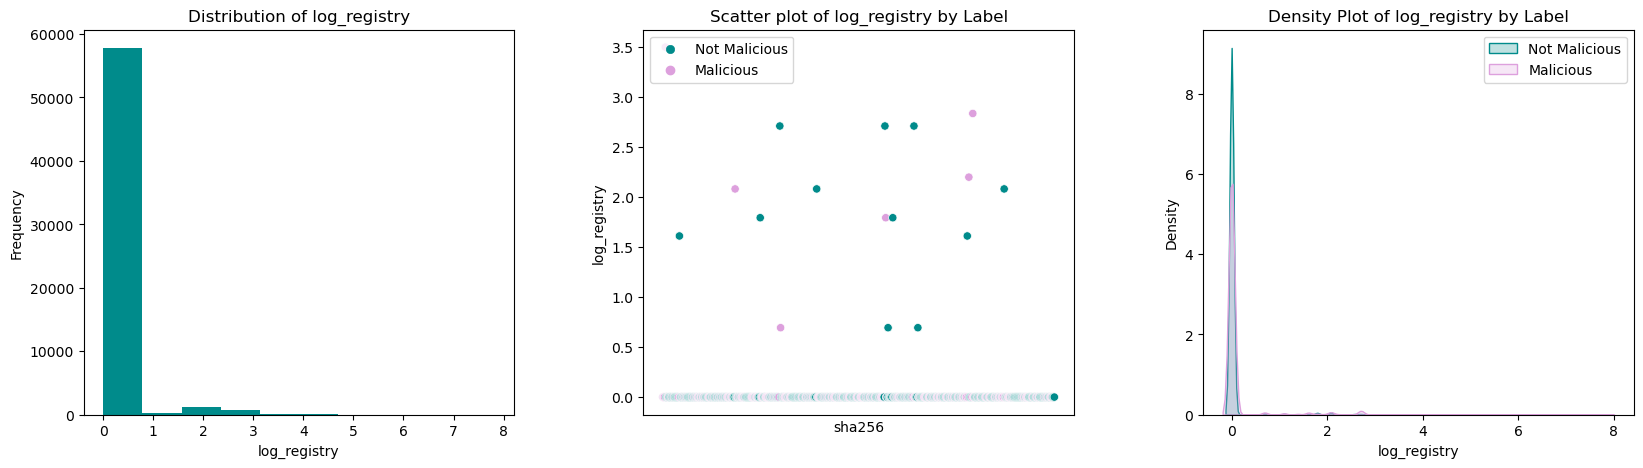

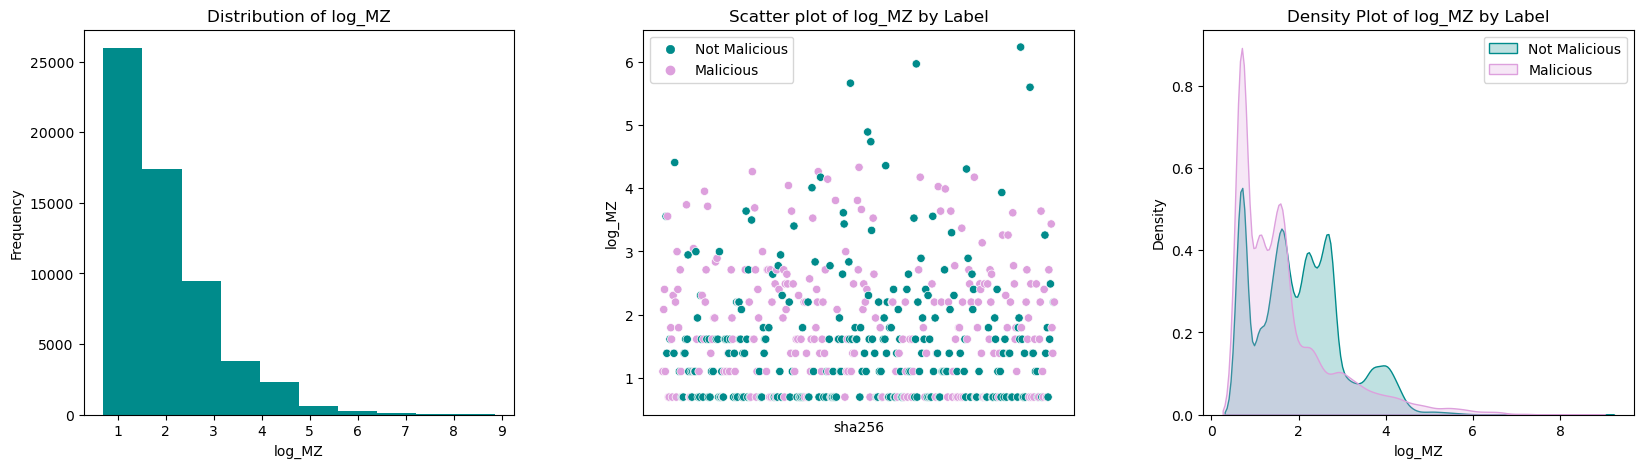

In [20]:
for feature in log_feature_list:
    feature_exploration(feature,df)

הרצנו אקספלורציה על כל הפיצרים החדשים כדי לראות את הגרפים שלהם. ואכן נראה כי הפיצ'רים החדשים מתפלגים בצורה שוויונית יותר על פני הדאטה ולכן הרצת מודלים על הפיצ'רים החדשים תאפשר קומבינציות לא לינאריות שייתנו ציונים טובים יותר.

### התמודדות עם ערכים חריגים

בעזרת הגרפים ראינו כי לרוב הפיצ'רים (פרט ל-3) יש היתכנות לתצפיות חריגות שנשקול להסיר.
הרצנו את כל המודלים שלנו לפני ואחרי שהסרנו את התצפיות החריגות וראינו שבכל המודלים לא השתנה הציון ROC-AUC
פרט למודל random forest ששם הציון על המדגם אימון ירד ב0.01

לכן, החלטנו שאנחנו מעדיפים לא להוריד תצפיות חריגות היות ואין שינוי בציוני המודלים ועל מנת להישאר עם הדאטה המלא.



In [21]:
def removing_outliers(data):
    total = 0
    for feature in feature_list_num:
        if (feature == 'A' or feature == 'log_size' or feature == 'B'):
            continue   
        else:
            threshold = np.percentile(data[feature], 99)  # Set the threshold as the 99th percentile
            curr_shape = data.shape[0]
            data = data[data[feature] <= threshold]  # Filter out samples below or equal to the threshold
            outliers_in_feature = curr_shape - data.shape[0]
            print('the amount of outliers in feature %s is %d' %(feature, outliers_in_feature))
            total = total + outliers_in_feature    
        
        
    print("Total outliers that were removed is %d" %(total))

### התמודדות עם משתנים קטגוריאליים

נזכיר כי תת הקטגוריות של הפיצ'ר C אינן משפיעות על הלייבל, כיוון שההתפלגות של הלייבל זהה בין הערכים השונים של פיצ'ר זה.
לכן הוחלט להסירו, נעשה זאת בהמשך.

כעת, נתמקד בfile_type_trid

In [22]:
df['file_type_trid'].nunique()

89

נראה כי יש 89 ערכים חד-חד ערכיים לפיצ'ר זה

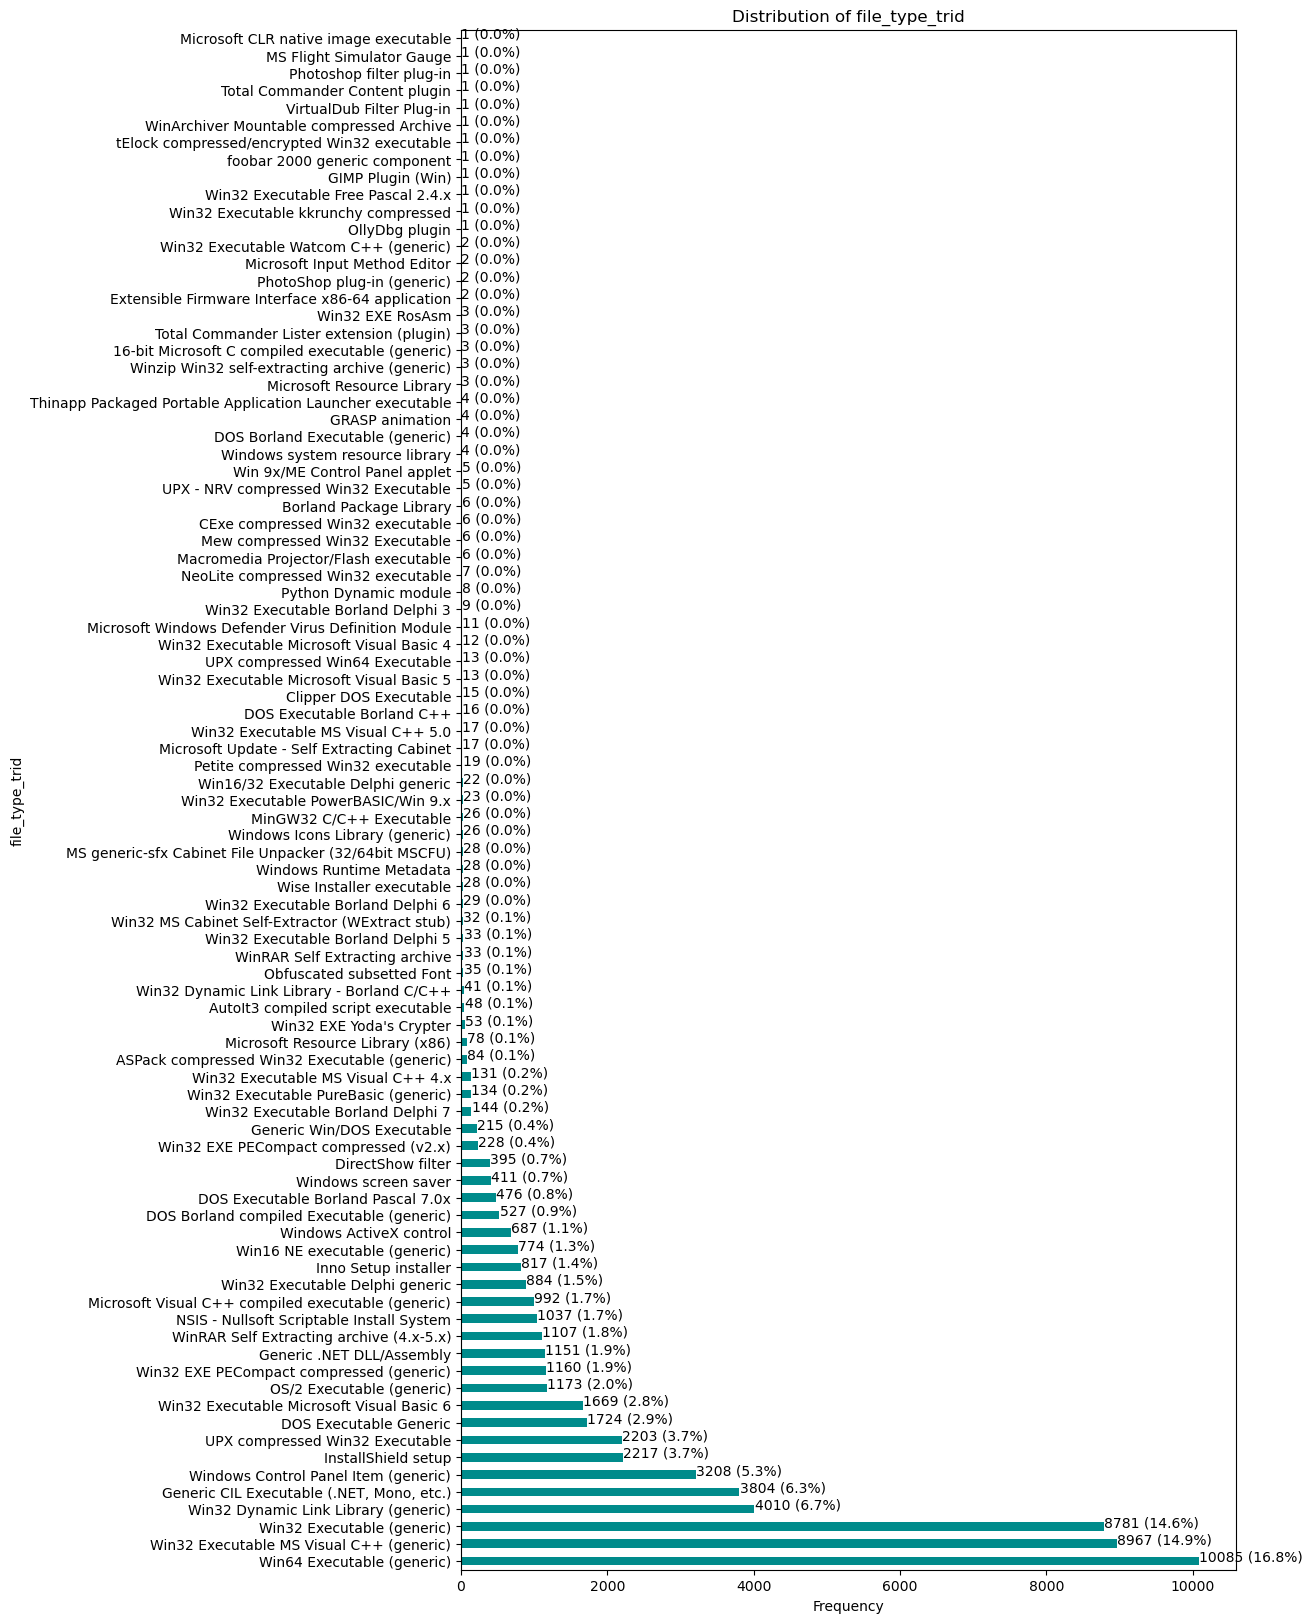

In [23]:

plt.figure(figsize=(10, 20))
ax = df['file_type_trid'].value_counts().plot.barh(color='darkcyan')

# Calculate percentages
total_count = len(df['file_type_trid'])
percentages = df['file_type_trid'].value_counts() / total_count * 100

# Add numbers and percentages to the bars
for i, (value, percentage) in enumerate(zip(df['file_type_trid'].value_counts(), percentages)):
    ax.text(value + 3, i, f'{value} ({percentage:.1f}%)', color='black')

plt.xlabel('Frequency')
plt.ylabel('file_type_trid')
plt.title(f'Distribution of file_type_trid')
plt.show()


עולה כי לפיצ'ר הזה המון ערכים חד חד ערכיים. מה שמעניין הוא שמעט מהם שכיחים.
 ,לכן נעשה אגרגציה לכל הערכים שכמות התצפיות עבור כל ערך נמוך מ2% מכלל התצפיות
 ונקרא לקטגוריה המאוגדת - other.

 החלטנו להוריד 2 אחוז מכיוון שישנם תתי קטגוריות רבות שנמצאות מתחת ל-2% מהדאטה, קטגוריות אלה לא משפיעות על המודל הנבחר ורק מעלות לו את ה-complexity.
 

In [24]:
#קודם נגדיר את תנאי הסף ונמצא את התצפיות שנמצאות מתחת לסף
def aggregate_file_type_trid(data): 
    
    # Get the value counts for the "file_type_trid" feature
    value_counts = data['file_type_trid'].value_counts()

    # Calculate the threshold as a percentage of the total number of samples
    threshold_percent = 2 # 2% of the data
    threshold = (threshold_percent / 100) * len(data)

    # Identify the values below the threshold
    below_threshold = value_counts[value_counts < threshold].index
    
    return below_threshold


In [25]:
#data_aggregation_based - על בסיס איזה דאטה עשינו את האגרגציה
#data_aggregaion_apply - על איזה דאטה נרצה להכיל את האגרגרציה

def apply_aggregation(data_aggregation_based, data_aggregation_apply):
    below_threshold = aggregate_file_type_trid(data_aggregation_based)
    # Create a new category "other" for values below the threshold
    data_aggregation_apply.loc[data_aggregation_apply['file_type_trid'].isin(below_threshold), 'file_type_trid'] = "other"
    return data_aggregation_apply

In [26]:
df_new = apply_aggregation(df,df)

נסתכל על התפלגות ערכי הפיצ'ר לאחר האגרגציה

In [27]:
df_new['file_type_trid'].nunique()

11

כמות הערכים החד חד ערכיים הצטמצמה ל11

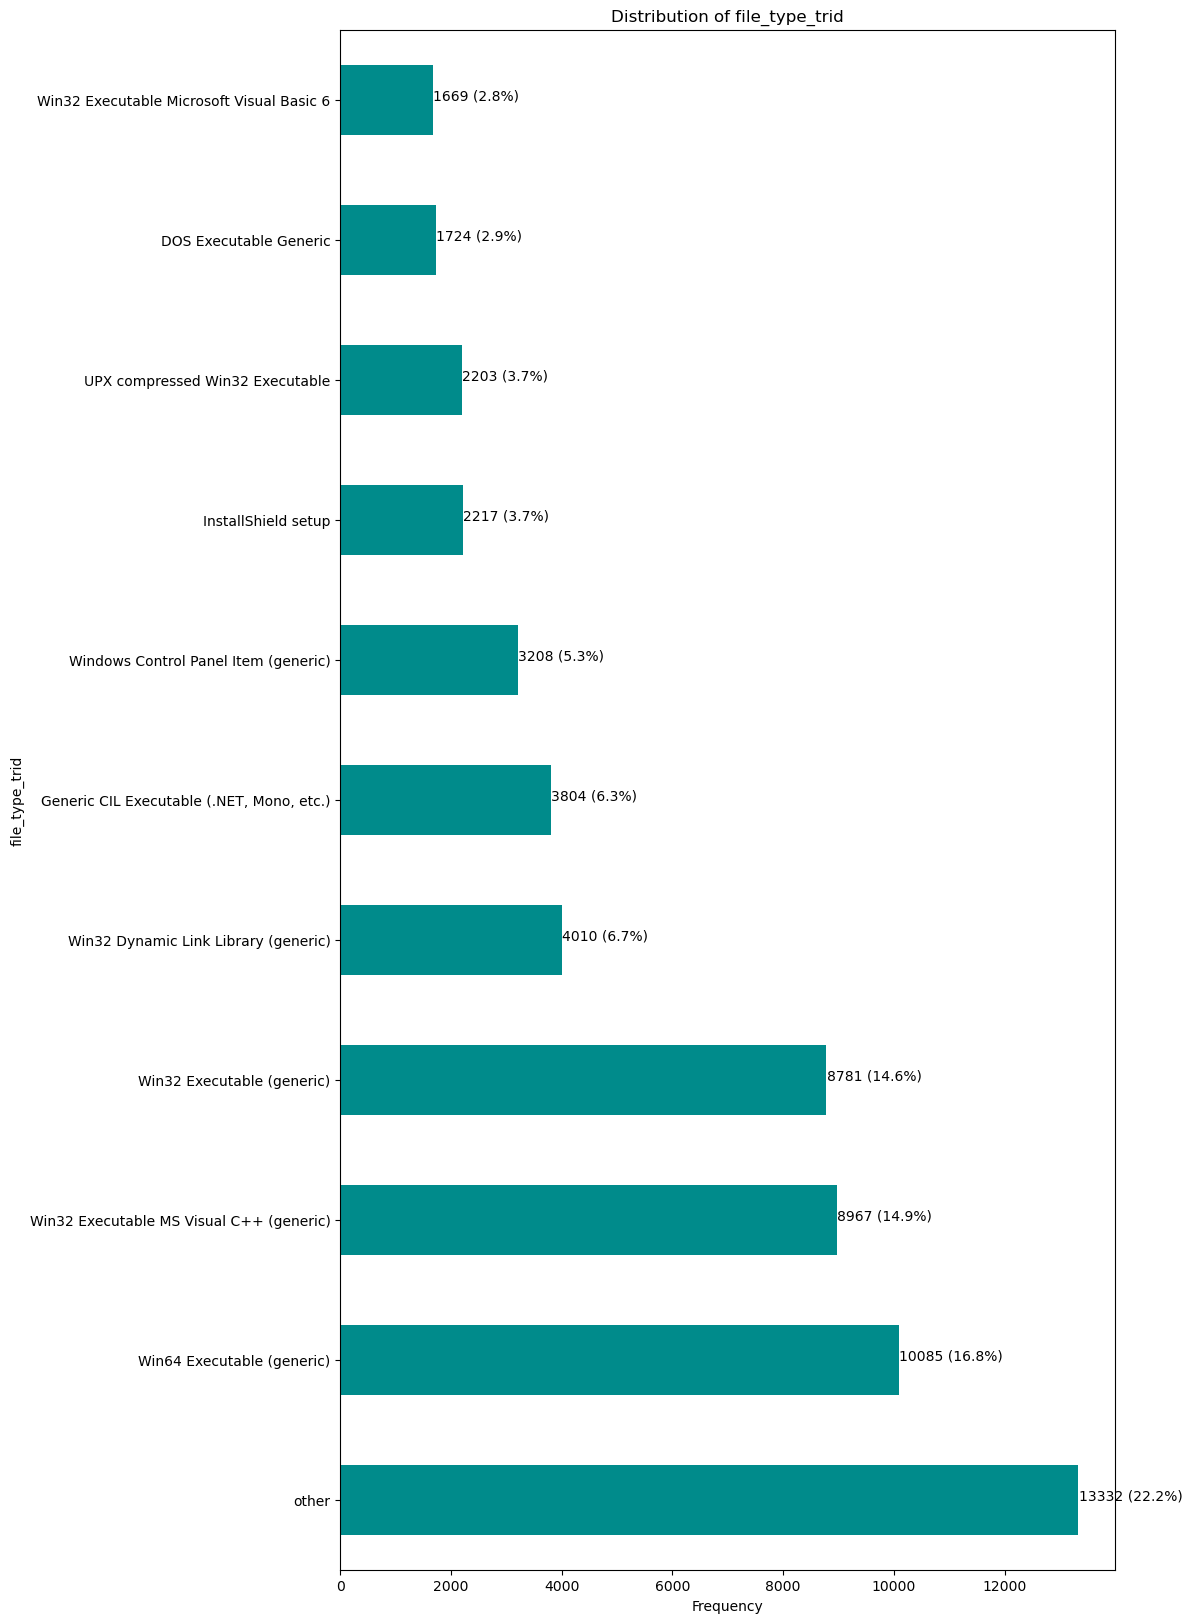

In [28]:

plt.figure(figsize=(10, 20))
ax = df_new['file_type_trid'].value_counts().plot.barh(color='darkcyan')

# Calculate percentages
total_count = len(df_new['file_type_trid'])
percentages = df_new['file_type_trid'].value_counts() / total_count * 100

# Add numbers and percentages to the bars
for i, (value, percentage) in enumerate(zip(df_new['file_type_trid'].value_counts(), percentages)):
    ax.text(value + 3, i, f'{value} ({percentage:.1f}%)', color='black')

plt.xlabel('Frequency')
plt.ylabel('file_type_trid')
plt.title(f'Distribution of file_type_trid')
plt.show()


לאחר האגרגרציה נרצה לבדוק איך נראית ההתפלגות של הלייבלים בין הערכים החדשים של פיצ'ר זה. החשיבה מאחורי זה היא שאם ההתפלגות לייבלים בין הערכים השונים של פיצ'ר זה הייתה דומה מאוד, יכולנו אולי להסיר את הפיצ'ר הזה.

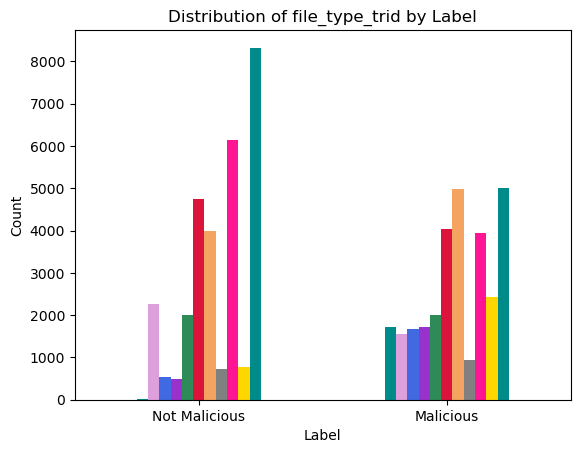

In [29]:

counts = df_new.groupby([df_new['label'], df_new['file_type_trid']]).size().unstack()
colors = ['darkcyan', 'plum','royalblue','darkorchid','seagreen','crimson','sandybrown','grey','deeppink','gold']
ax = counts.plot(kind='bar', stacked=False, color=colors)

plt.xlabel('Label')
ax.set_xticklabels(['Not Malicious', 'Malicious'], rotation=0) 
plt.ylabel('Count')
plt.title(f'Distribution of file_type_trid by Label')

plt.xlim(-0.5, 1.5)

ax.legend().remove()

plt.show()


ניתן לראות לפי הגרף למעלה כי ההתפלגויות של הלייבלים לא דומות, ולכן לא נסיר פיצ'ר זה

בשלב הבא, ניקח את הפיצ'ר הקטגוריאלי ובאמצעות onehotencoder נפצל אותו לערכים נפרדים, כאשר כל ערך יומר לעמודה.

 בנוסף, השתמשנו בשיטה זו כדי לתת משקל שווה לכל עמודה חדשה

In [30]:
#את הפיצול של המשתנה הקטגוריאלי נעשה לפי הדאטה סט של האימון

def encode_categorical_filetypetrid_train(train_data):
    train_data.reset_index(inplace=True)

    # Reshape the 'file_type_trid' column
    category_reshaped = np.array(train_data['file_type_trid']).reshape(-1, 1)

    # Initialize and fit the OneHotEncoder
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    df_encoded = encoder.fit_transform(category_reshaped)

    # Create column names for the encoded categories
    category_names = [f'category_{category}' for category in encoder.categories_[0]]

    # Create a DataFrame from the encoded categories
    df_encoded_train = pd.DataFrame(df_encoded, columns=category_names)

    # Concatenate the encoded columns with the original training DataFrame
    train_data = pd.concat([train_data, df_encoded_train], axis=1)

    # Drop the 'file_type_trid' column
    cleaned_train_data = train_data.drop('file_type_trid', axis=1)

    return cleaned_train_data, encoder


In [31]:
#פונקציה שמיישמת את הפיצול של המשתנה הקטגוריאלי (על בסיס הדאטה של האימון) על הדאטה של המבחן

def encode_categorical_filetypetrid_test(test_data, encoder):
    test_data.reset_index(inplace=True)

    # Reshape the 'file_type_trid' column
    category_reshaped_test = np.array(test_data['file_type_trid']).reshape(-1, 1)

    # Apply the same encoder on the test data using the transform() method
    df_encoded_test = encoder.transform(category_reshaped_test)

    # Create column names for the encoded categories
    category_names = [f'category_{category}' for category in encoder.categories_[0]]

    # Create a DataFrame from the encoded categories for the test data
    df_encoded_test = pd.DataFrame(df_encoded_test, columns=category_names)

    # Concatenate the encoded columns with the original test DataFrame
    test_data = pd.concat([test_data, df_encoded_test], axis=1)

    # Drop the 'file_type_trid' column
    cleaned_test_data = test_data.drop('file_type_trid', axis=1)

    return cleaned_test_data

In [32]:
cleaned_df_new, encoder = encode_categorical_filetypetrid_train(df_new)

### מחיקת פיצ'רים

נרצה למחוק בסך הכל 3 פיצ'רים:
- feature 'A' מכיוון שלפי גרף ההתפלגות הלייבלים על הערכים של פיצ'ר זה, ניתן לראות כי ההתפלגות מאוד דומה עד כדי זהה ולכן לפיצ'ר זה אין השפעה מספקת על הסיווג הסופי.

- feature 'C' - גם פה, ראינו בשלב האקספלורציה כי עבור כל ערך בפיצ'ר זה ההתפלגות של הלייבלים דומה
 מאוד עד כדי זהה.

- features 'symbols' and 'log_symbols' - ראינו כי תרומתם למודלים מוגבלת מאוד (ממוקמים בסוף רשימת ה-Feature Importance) לכן הוחלט להורידם

- feature 'category_other' - פיצ'ר זה מורכבת מהרבה תתי קטגוריוית דאמיז ואינה מלמדת דבר על האם הקובץ זדוני או לא מבחינת אינטואיציה.


In [33]:
def delete_features(data):
    columns_to_delete = ['C','A', 'symbols','log_symbols','C', 'category_other']
    feature_list_num.remove('A')
    feature_list_num.remove('symbols')
    feature_list_num.remove('log_symbols')
    feature_list_cat.remove('C')
    
    cleaned_df_new = data.drop(columns_to_delete, axis=1) #נסיר את העמודות הרלוונטיות

    return cleaned_df_new

In [34]:
cleaned_df_new = delete_features(cleaned_df_new)

### פיצול דאטה

In [35]:
def split_data_x_y(data):
    data = data.set_index('sha256')

    y = data['label']

    X = data.drop(['label'], axis=1)
    return X,y


In [36]:
X,y = split_data_x_y(cleaned_df_new)

### נירמול הנתונים

מהחלק של האקספלוריישן ראינו כי למשתנים יש סדרי גודל שונים.
כאשר המשתנים שלנו לא באותו קנה מידה, זה יכול להוביל לקשיים להמחיש את הנתונים, ואף לפגוע בביצועי הניבוי של המודלים בהם נשתמש בהמשך. 

לכן נבחר לנרמל את הדאטא כדי להתמודד עם קני המידה השונים של המידע
בגלל שנרצה לבחון הורדת מימדים באמצעות שיטת PCA ובאמצעות FS.

StandardScaler אנו נבחר לבצע סטנדרטיזציה באמצעות 
וזאת בגלל בשיטת הורדת מימדים  אנו צריכים שלכל משתנה יהיה ממוצע 0 ובנוסף היא עובדת טוב יותר כאשר השונות של כל משתנה היא 1

In [37]:
def normalize_data(x):
# normalize to have 0 mean and 1 variance (according to train distribution) for pca & FS
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(x)
    print(f'X.shape: {X_norm.shape}')
    return X_norm


In [38]:
X_norm = normalize_data(X)

X.shape: (60000, 39)


### הקטנת מימדיות הבעיה

לאחר הטיפול בכל הפיצ'רים בדאטה, נותרנו עם 39 מימדים בסה"כ.

מימדיות גדולה עלולה ליצור overfitting.
ככל שיש יותר מימדים, השונות והגמישות של המודל עולה ואז יכולה להיות חוסר התאמה לדאטה סט של המבחן.

#### PCA

In [39]:
def pca(x):
    # Apply PCA on the normalized data
    pca = PCA(0.99)
    x_pca = pca.fit_transform(x)

    # Access the principal components and explained variance ratios
    principal_components = pca.components_
    explained_variance_ratios = pca.explained_variance_ratio_
    print(f'number of components which preserve at least {round(sum(explained_variance_ratios),2)}% of the variance: {len(principal_components)}')
    
    # Get the indices of the top features for each principal component
    top_features_indices = np.argsort(np.abs(pca.components_), axis=1)[:, ::-1]

    # Create a list to store the chosen features
    chosen_features = []

    # Iterate over the principal components and add the chosen features to the list
    for feature_indices in top_features_indices:
        chosen_features.extend([X.columns[idx] for idx in feature_indices])

    # Remove duplicates from the list of chosen features
    chosen_features = list(set(chosen_features))

    # Print the final list of chosen features
    print(chosen_features)

In [40]:
pca(X_norm)

number of components which preserve at least 0.99% of the variance: 36
['log_urls', 'vsize', 'log_imports', 'log_paths', 'log_printables', 'category_Win32 Dynamic Link Library (generic)', 'log_size', 'category_Windows Control Panel Item (generic)', 'category_Win64 Executable (generic)', 'avlength', 'paths', 'urls', 'imports', 'category_UPX compressed Win32 Executable', 'log_registry', 'exports', 'log_MZ', 'numstrings', 'has_tls', 'log_exports', 'registry', 'category_InstallShield setup', 'category_Win32 Executable (generic)', 'log_avlength', 'has_relocations', 'category_Win32 Executable MS Visual C++ (generic)', 'has_signature', 'size', 'B', 'category_Win32 Executable Microsoft Visual Basic 6', 'category_Generic CIL Executable (.NET, Mono, etc.)', 'category_DOS Executable Generic', 'file_type_prob_trid', 'MZ', 'printables', 'log_numstrings', 'has_resources', 'log_vsize', 'has_debug']


בשיטה זו לא קיבלנו הורדת מימדים משמעותית - 39 ל-36. ולכן נרצה לבדוק שיטה נוספת

#### Foward selection

In [41]:
def get_sigma_hat_squared(X, y):
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    rss = np.sum((y - lr_model.predict(X)) ** 2)
    return rss / (X.shape[0] - X.shape[1] - 1)

def get_mallows_cp_score(X, y, sigma_hat_squared):
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    mse = mean_squared_error(y, lr_model.predict(X))
    n = X.shape[0]
    d = X.shape[1]
    cp = mse + sigma_hat_squared * 2 * ((d + 1) / n)
    return cp

def add_feature(X: np.array ,y: np.array ,current_features: List[int] , sigma_hat_squared: float) -> Dict:

    num_of_features = X.shape[1]
    best_score = np.inf
    for i in range(num_of_features):
        if i in current_features:
            #feature shouldn't be selected because its already included
            continue
        
        potential_feature_lst = current_features + [i]
        x_red = X[:,potential_feature_lst]
        model_score = get_mallows_cp_score(x_red,y,sigma_hat_squared)
        #compare score with best
        if model_score < best_score:
            best_score = model_score
            best_features_lst = potential_feature_lst.copy()
              
    return {'features':sorted(best_features_lst),'score':best_score}


def forward_selection(X: np.array, y: np.array) -> List[int]:

    num_of_features = X.shape[1]
    current_features = []
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)

    models_lst = []
    for i in range(num_of_features):
        res = add_feature(X,y,current_features,sigma_hat_squared)
        models_lst.append(res)
        current_features = models_lst[-1]['features']
    
    #Plotting
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(range(1,len(scores_lst)+1),scores_lst)
    plt.xlabel("number of features")
    plt.ylabel("Mallows cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

In [42]:
def run_FS(data,x,y):
    selected_features = forward_selection(x, y)
    chosen_features = [data.columns[i] for i in selected_features]
    num_chosen_features = len(chosen_features)
    print("Number of Chosen Features:", num_chosen_features)
    print("Chosen features:", chosen_features)
    return selected_features, chosen_features
    

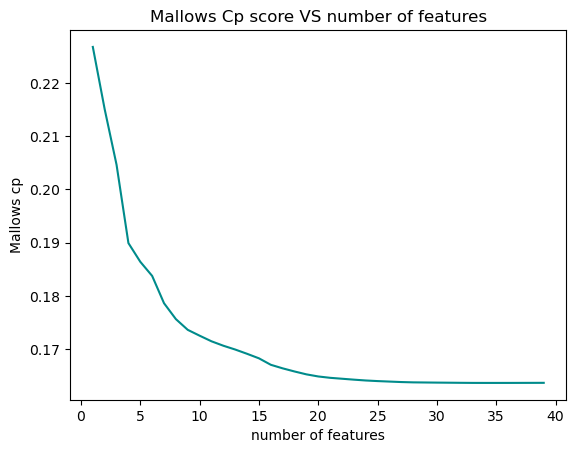

Number of Chosen Features: 35
Chosen features: ['size', 'vsize', 'imports', 'exports', 'has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls', 'paths', 'urls', 'MZ', 'printables', 'file_type_prob_trid', 'B', 'log_vsize', 'log_imports', 'log_exports', 'log_numstrings', 'log_avlength', 'log_printables', 'log_paths', 'log_urls', 'log_registry', 'log_MZ', 'category_DOS Executable Generic', 'category_Generic CIL Executable (.NET, Mono, etc.)', 'category_InstallShield setup', 'category_UPX compressed Win32 Executable', 'category_Win32 Dynamic Link Library (generic)', 'category_Win32 Executable (generic)', 'category_Win32 Executable MS Visual C++ (generic)', 'category_Win32 Executable Microsoft Visual Basic 6', 'category_Win64 Executable (generic)', 'category_Windows Control Panel Item (generic)']


In [43]:
selected_features, chosen_features = run_FS(X,X_norm,y)

In [44]:
def apply_fs_on_data(X):
    X_forward_reduced = X[:,selected_features]
    return X_forward_reduced

באמצעות שיטה זו הורדנו את מימדיות הבעיה מ39 ל-35.
הגרף למעלה מציג את הקשר בין מספר הפיצ'רים לבין הציון שמאפשר להעריך את ההתאמה של מודל רגרסיה באמצעות צמצום שגיאות המודל. ככל שהציון נמוך יותר כל הניבוי מודל מדויק יותר.


 נבחר לעבוד עם FS כי
 שיטה זו הצליחה להוריד יותר את כמות המימדים מאשר PCA
 


In [45]:
X_forward_reduced = apply_fs_on_data(X_norm)

<AxesSubplot:>

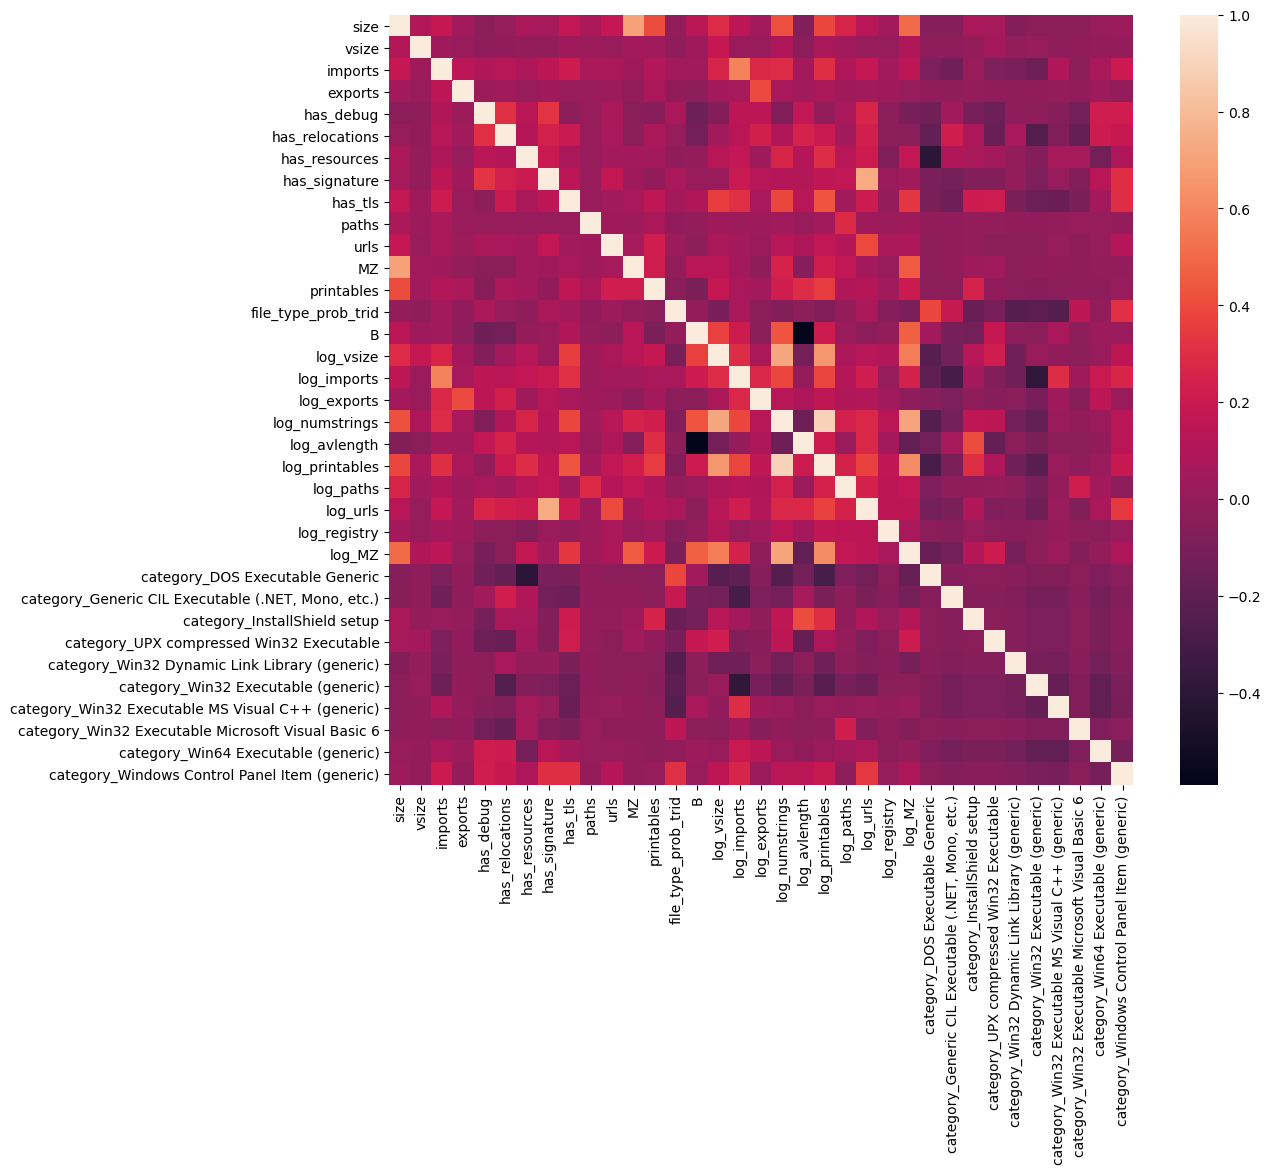

In [46]:
X_forward_reduced_df = pd.DataFrame(X_forward_reduced)
X_forward_reduced_df.columns = chosen_features

plt.figure(figsize=(12, 10))

sns.heatmap(X_forward_reduced_df.corr(), xticklabels=chosen_features,
yticklabels=chosen_features)

עולה ממפת הקורלציות כי:

1. קיימת קורלציה חיובית חזקה בין הפיצ'רים 'log_numstrings' and 'log_printables' (0.89)
2. קיימת קורלציה חיובית בין הפיצ'רים log_urls and has_signature (0.74)
3. קורלציה חיובית בין הפיצ'רים size and MZ (0.7)
4. קורלציה שלילית בין הפיצ'רים B and log_avlength (-0.6)

### מחיקת פיצ'רים נוספת

בנוסף הוחלט כי מבין כל הקורלציות הגבוהות שציונו לעיל להוריד רק את המשתנה numstrings מכיוון ששאר הפיצ'רים תורמים במידה רבה לתוצאות המודל הנבחר.

על סמך מפת הקורלציות לעיל, החלטנו למחוק 2 פיצ'רים נוספים:

- feature 'log_numstrings' - יש קורלציה חיובית חזקה מאוד (0.89) עם log_printables.
ונראה כי log_numstrings לא תורם כלל למודל הסופי שלנו

In [47]:
def delete_features2(data):
    columns_to_delete = ['log_numstrings']
    feature_list_num.remove('log_numstrings')
    
    cleaned_df_new = data.drop(columns_to_delete, axis=1)#נסיר את העמודות הרלוונטיות

    return cleaned_df_new

In [48]:
cleaned_df_new = delete_features2(cleaned_df_new)

# מודלים


In [49]:
#utility_models

models = {}

def model_train_scores(X,y,model,n_folds): #פונקציה שמריצה את שאר הפונקציות
    plot_roc_curve_for_each_fold(X,y,model,n_folds)
    k_fold_cross_validation(X,y,model,n_folds)

def plot_roc_curve_for_each_fold(X, y, model, n_folds):
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        model.fit(X[train], y[train])
        y_pred_proba = model.predict_proba(X[test])[:, 1]
        fpr, tpr, _ = roc_curve(y[test], y_pred_proba)
        roc_auc = roc_auc_score(y[test], y_pred_proba)
    

        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold {} (AUC = {:.2f})'.format(i, roc_auc))

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_auc = np.std(aucs)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, color='rebeccapurple',
            label=r'Mean ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc),
            lw=2, alpha=.8)


    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="ROC curve for the Model - on train data - {} K-folds".format(n_folds))
    ax.legend(loc="lower right")
    plt.show()

    
#k-fold cross validation
def k_fold_cross_validation(X,y,model, n_folds):
    # Create a StratifiedKFold object
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Perform k-fold cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring="roc_auc")

    # Calculate and print the mean accuracy score
    mean_score = scores.mean()
    print(f'Mean of train Cross-Validation Score: {mean_score}')
        
        
def roc_auc_score_valdiation(model,X,y):
    model_name = model.__class__.__name__
    model_prediction = model.predict(X)
    score = roc_auc_score(y,model_prediction)
    models[model] = score
    
    print(f"The roc_auc_score of {model_name} model on the validation set is: %0.2f"%(score))

הציון של כל מודל יחושב בשתי דרכים - 
1. ROC-AUC
2. K fold cross validation

### פיצול לאימון וולידציה

In [50]:
def split_train_val(X,y):
    #split train to train and validation
    X_train ,X_val ,y_train, y_val = train_test_split(X,y,test_size = 0.15, random_state= 42, shuffle=True)
    return X_train ,X_val ,y_train, y_val

In [51]:
X_train ,X_val ,y_train, y_val = split_train_val(X_forward_reduced,y)

עבור כל מודל (פרט לרגרסיה לוגיסטית) ננסה לחפש את ההיפר פרמטרים המיטביים ביותר באמצעות GridSearchCV

### Logistic Regression

 ניצור וקטור של ערכים שונים עבור עבור ההיפרפרמטר למדא.
היפר-פרמטר זה מתייחס למידת הרגולריזציה של המודל. 

ערך נמוך של רגולריזציה-
bias יורד
שונות עולה

ערך גבוה של רגולריזציה - 
bias עולה
שונות יורדת (עוזר להפחית overfitting)

In [52]:
def hyperparams_logistic_reg(X_train,y_train,X_val,y_val):
    
    powers = range(-10,3)
    Cs = [10**p for p in powers]
    c_score = []
    error_score = []


    for c in Cs:
        clf = LogisticRegression(penalty="l2", solver = "liblinear", C=c) 
        clf.fit(X_train, y_train)
        c_score.append(clf.score(X_val, y_val))
        error_score.append(1 - clf.score(X_val, y_val)) 
        

    #score_plot
    plt.plot(powers, c_score, color='darkcyan')
    plt.show()

    #error plot
    # Plotting the validation error graph
    plt.plot(Cs, error_score, marker='o', label='Validation Error')
    plt.xscale('log')
    plt.xlabel('C values')
    plt.ylabel('Error')
    plt.title('Validation Error vs. C values')
    plt.legend()
    plt.grid(True)
    plt.show()
        
    optimal_c_logistic_regression = Cs[c_score.index(max(c_score))]
    print("The optimal lambda is: ", 1/optimal_c_logistic_regression, "\n( Best C:", optimal_c_logistic_regression, ")")
    return optimal_c_logistic_regression

נריץ את המודל עם פרמטר למדא האופטימלי שמצאנו. הפרמטרים השונים שניתנו למודל הינם ערכי ברירת המחדל עבור מודל רגרסיה לוגיסטית

In [53]:
def apply_logistic_reg(X_train,y_train,X_val,y_val):
    optimal_c_logistic_regression = hyperparams_logistic_reg(X_train,y_train,X_val,y_val)
    logreg = LogisticRegression(penalty="l2",solver = "liblinear", C=optimal_c_logistic_regression)
    logreg.fit(X_train,y_train)
    return logreg

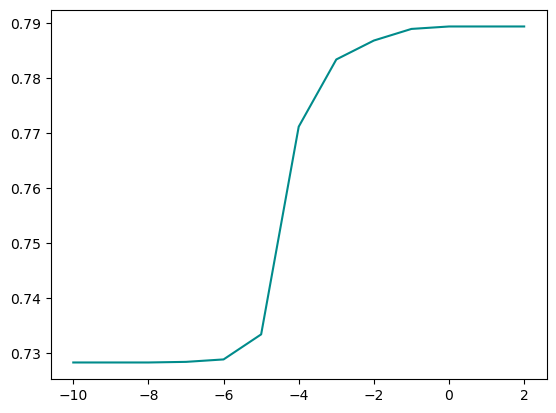

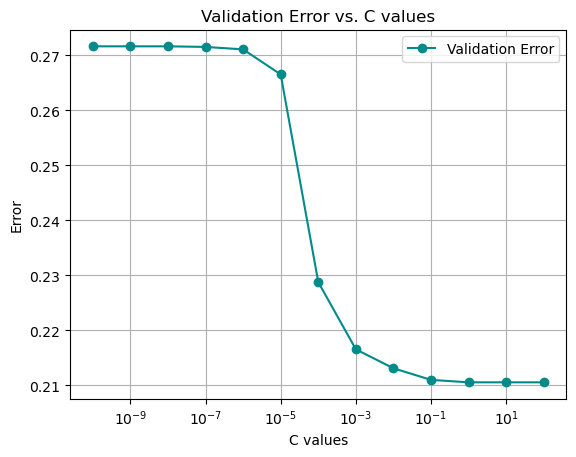

The optimal lambda is:  1.0 
( Best C: 1 )


In [54]:
logreg = apply_logistic_reg(X_train,y_train,X_val,y_val)

בשני הגרפים ניתן לראות את ערכי ההיפרפרמטר כפונקציה של גודל השגיאה של המודל על נתוני הולידציה.
ניתן לראות שהערך האופטימלי הוא איפה שהשגיאה היא הנמוכה ביותר.

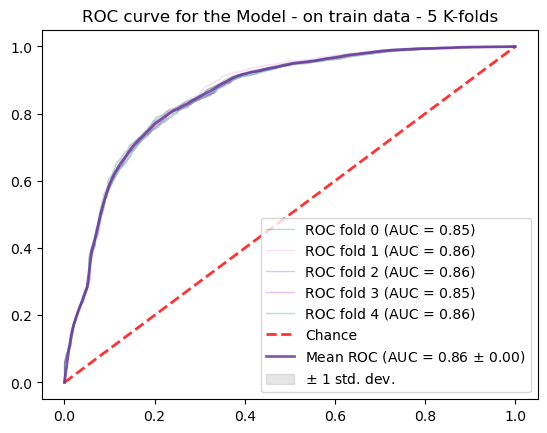

Mean of train Cross-Validation Score: 0.8564686180879899


In [55]:
model_train_scores(X_train,y_train,logreg,5)

In [56]:
roc_auc_score_valdiation(logreg,X_val,y_val)

The roc_auc_score of LogisticRegression model on the validation set is: 0.79


ניתן לראות שהמודל רגרסיה לוגיסטית חזה נכון 85% מהדאטה שמוגדר זדוני של האימון.
בנוסף המודל חזה נכון 79% מהדאטה שמוגדר זדוני של הולידציה.

אמנם הפער בביצועים של המודל בין האימון לולידציה לא גדול אבל יכול להיות שהפער נובע מהסיבות הבאות:
1. ייתכן והמודל מאומן יתר על המידה על הדאטה של האימון.
2. בחלק של האקספלורציה ראינו כי לא מעט משתנים בדאטה לא מתפלגים בצורה לינארית ולכן יכול להיות שסיווג לינארי לא בהכרח מתאים לבעיית הסיווג שלנו.
3. המודל מניח שיש מעט מולטיקולינאריות בין משתנים, אך לפי המפת הקורלציה שביצענו לאחר הורדת המימדים, נראה שיש משתנים שעדיין יש בינהם תלות ולכן לא מתקיימת ההנחה של המודל והדבר עשוי לפגוע בביצועי המודל.
4. לאחר הורדת המימדים נותרנו עם 35 משתנים מסבירים, הדבר יכול להיות בעייתי כי המודל עובד טוב יותר ככל שכמות הפיצ'רים שעליו הוא מתאמן פשוט יותר.
5. ייתכן שהפער בביצועים בין האימון לולידציה נובע מכך שהדאטה סט של האימון גדול יותר מהולדיציה.
6. ייתכן שלמרות הטיפול בדאטה שעשינו בעיבוד מקדים, עדיין יש תצפיות חריגות שפוגעות בביצועים של המודל, שכן מודל רגרסיה לוגיסטית רגיש לתצפיות חריגות.

על מנת לשפר את יכולת ההכללה של המודל יש לנסות ולהוריד את מורכבות של המודל

### KNN

תחילת נבדוק מה ההיפר-פרמטרים שמביאים לביצועים הכי טובים של המודל:

1.  n_neighbors - מספר השכנים של נקודה שלפיהם ייקבע הסיווג של כל דגימה.
ערך גבוה של היפר-פרמטר זה מוריד את ההשפעה של תצפיות חריגות, מה שיכול להוביל לbias גבוה.
ערך נמוך של היפר-פרמטר זה יכול להוביל לשונות גבוהה בגלל שהמודל רגיש יותר לתצפיות חריגות, מה שיכול להוביל לoverfitting.

2. weights  פונקציית המשקולות המשמשת לחיזוי. 
המשקולות שבחרנו לבחון הן:

'uniform' - כל הנקודות מקבלות משקלים אחידים, כלומר תורמות באותה מידה למודל.
שיטה זו של משקול אחיד לא משקפת את החשיבות של כל שכן לעומת שאר הנקודות.

'distance' - שיטת משקול כך ששכנים קרובים יותר לנקודה כלשהי יש השפעה רבה יותר (יותר משקל) מאשר לשכנים רחוקים יותר מנקודה זו. עם שיטה זו ייתכן והמודל ייתן יותר מדי חשיבות למיקום היחסי של השכנים לכל נקודה, מה שיכול להוביל לoverfitting.



In [57]:
def hyperparams_knn(X,y):
    # Define the parameter grid
    param_grid = {
        'n_neighbors': [200,120,100,80,60,50,20,10],
        'weights': ['uniform', 'distance']
    }

    #Grid Search Cross-Validation
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5)
    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)
    
    results = grid_search.cv_results_

    # Extract data for 'uniform' weight
    k_values_uniform = results['param_n_neighbors'][::2]
    scores_uniform = results['mean_test_score'][::2]

    # Convert k_values_uniform to integers
    k_values_uniform = [int(k) for k in k_values_uniform]

    # Extract data for 'distance' weight
    k_values_distance = results['param_n_neighbors'][1::2]
    scores_distance = results['mean_test_score'][1::2]

    # Convert k_values_distance to integers
    k_values_distance = [int(k) for k in k_values_distance]

    # Plot both lines on the same graph
    plt.plot(k_values_uniform, scores_uniform, marker='o', label='Uniform Weight')
    plt.plot(k_values_distance, scores_distance, marker='o', label='Distance Weight')

    plt.xlabel('K')
    plt.ylabel('Score (ROC-AUC)')
    plt.title('Correlation between Score and K')
    plt.grid(True)
    plt.legend()

    plt.show()

    # Select Best Hyperparameters
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_


    print("Best Hyperparameters:", best_params)
    print("ROC-AUC Score:", best_score)
        
    return best_params


נריץ את המודל עם ההיפר פרמטרים המיטבים ביותר

In [58]:
def apply_knn(X,y):
    best_params = hyperparams_knn(X,y)
    knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])
    knn.fit(X_train,y_train)
    return knn

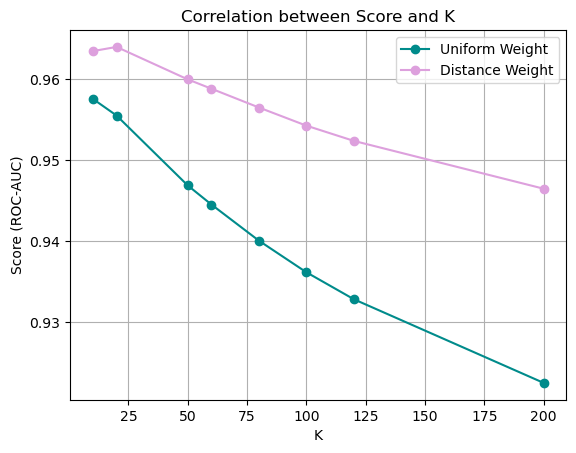

Best Hyperparameters: {'n_neighbors': 20, 'weights': 'distance'}
ROC-AUC Score: 0.9639838932711993


In [59]:
knn = apply_knn(X_train,y_train)

בגרף ניתן לראות את ערכי ההיפר פרמטרים כפונקציה של ציון הROC-AUC
כאשר ציר איקס מייצג את כמות השכנים ושיטות משקול השונות מיוצגות ע"י גרפים שונים.

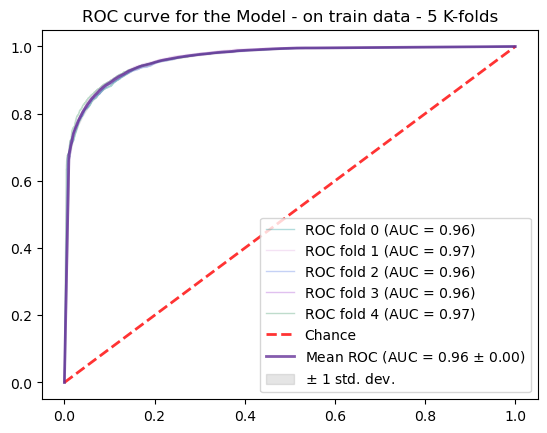

Mean of train Cross-Validation Score: 0.9640286376020237


In [60]:
model_train_scores(X_train,y_train,knn,5)

In [61]:
roc_auc_score_valdiation(knn,X_val,y_val)

The roc_auc_score of KNeighborsClassifier model on the validation set is: 0.90


ניתן לראות שמודל זה חזה נכון 96% מהדאטה שמוגדר זדוני של האימון.
בנוסף המודל חזה נכון 90% מהדאטה שמוגדר זדוני של הולידציה.

אמנם הפער בביצועים של המודל בין האימון לולידציה לא גדול אבל יכול להיות שהפער נובע מהסיבות הבאות:
1. ייתכן והמודל מאומן יתר על המידה על הדאטה של האימון.
2. מתוך הטווח שנתנו להיפר פרמטר שקובע את מספר השכנים, נבחר המספר 20 (המספר השני הכי קטן בטווח). יכול להיות שביחס לכמות הדגימות הגדולה במדגם האימון שלנו, מספר השכנים שנבחר קטן ומוביל לoverfitting.
3. העובדה שלא הסרנו ערכים חריגים יכולה לגרום לכך שתצפיות מסויימות יסווגו לא נכון בעקבות קרבתם לתצפית חריגה


Validation confusion Matrix: 



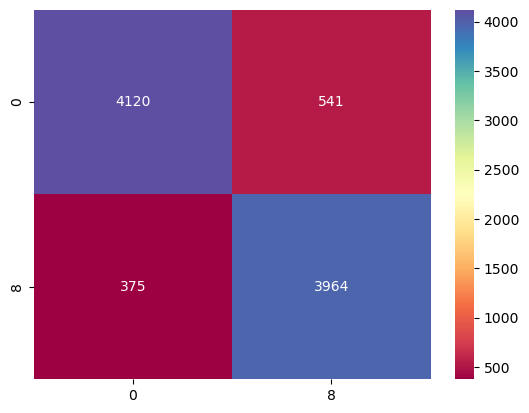

Validation Accuracy: 
 0.8982222222222223
Validation Recall: 
 0.9165739710789766


In [62]:
cm = confusion_matrix(y_val,knn.predict(X_val))
tn, fp, fn, tp = cm.ravel()
cm = np.array([[tp,fp],[fn,tn]])
sns.heatmap(cm,annot=True,fmt='g',cmap='Spectral', xticklabels = [0,8], yticklabels = [0,8])
print("\nValidation confusion Matrix: \n")
plt.show()
print("Validation Accuracy: \n", (tp+tn) / cm.sum())
print("Validation Recall: \n", (tp)/(tp+fn))

* 4115 true positive classifications - מודל זה סיווג 4115 קבצים זדוניים כזדוניים (צדק בסיווג) 
* 556 false positive classifications - המודל סיווג באופן שגוי 556 תצפיות - סיווג קבצים כזדוניים למרות שלא היו זדוניים.
* 380 false negative classifications - עבור 380 תצפיות, המודל חזה עבור קבצים זדוניים שמדובר בקבצים לא זדוניים
* 3949 true negative classifications - עבור 3949 תצפיות, המודל חזה שמדובר בקבצים לא זדוניים ואכן צדק בסיווג.

Validation Accuracy - מודל זה מצליח לסווג באופן נכון קבצים - אם הם קובץ זדוני או לא זדוני עבור 89.6% מכלל הקבצים.

Test Recall - אחוז המקרים בו המודל יחזה שהקובץ זדוני מכל המקרי שהקובץ אכן זדוני. כלומר מתוך כלל הקבצים הזדוניים, המודל הצליח לסווג נכונה עבור 91.5% מהם.

בסה"כ לפני הנתונים שהתקבלו נראה כי החיזוי של מודל זה די טוב


### Decision Tree

תחילת נבדוק מה ההיפר-פרמטרים שמביאים לביצועים הכי טובים של המודל:

1. criterion - 
gini - מודד את ההסתברות שמודל ייתן את הסיווג הלא נכון לתצפית.
שיטה זו אפקטיבית לדאטה סט עם שונות נמוכה.


    entropy - מודד את הכמות הממוצעת של מידע שנדרשת כדי לתת סיווג נכון לתצפית.

בהשוואה בין שני הקריטריונים:
- entropy יכול להוביל לעץ החלטה בעל bias נמוך יותר
- entropy יכול להוביל לעץ החלטה בעל גמישות ושונות גבוהה יותר

2. max depth - ככל שהעץ עמוק יותר הגמישות והשונות של המודל על הדאטה עולה (כל פיצול מוסיף לגמישות/שונות) מה שיכול ליצור overfitting.
בנוסף, ככל שהעץ עמוק יותר, הbias יורד

3. min samples split - ככל שהמספר גבוה יותר הדבר יכול למנוע מפיצולים מוקדמים מדי בעץ - כלומר ככל שהמספר גבוה יותר השונות קטנה וקטן הסיכוי לoverfitting.
בהתאם, מספר גבוה יותר של פרמטר זה גורם לעלייה של הbias. החסרון בכך הוא שפיצולים חשובים בעץ עלולים להתפספס

4. min samples leaf - ככל שהמספר גבוה יותר, השונות תיקטן(פחות יחס לתצפיות חריגות בדאטה)  וקטן הסיכוי לoverfitting
בהתאמה, מספר גבוה של פרמטר זה יגרום לbias גבוה.

In [63]:
def hyperparams_decisiontree(X,y):
    # Define the parameter grid
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None,3,5,10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [2, 5,10]
    }

    #Grid Search Cross-Validation
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='roc_auc', cv=5)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    results = grid_search.cv_results_
    param_criterion = results['param_criterion']
    param_max_depth = results['param_max_depth']
    param_min_samples_split = results['param_min_samples_split']
    param_min_samples_leaf = results['param_min_samples_leaf']
    scores = results['mean_test_score']

    # Convert hyperparameter values to strings
    param_criterion = [str(c) for c in param_criterion]
    param_max_depth = [str(d) if d else 'None' for d in param_max_depth]
    param_min_samples_split = [str(s) for s in param_min_samples_split]
    param_min_samples_leaf = [str(s) for s in param_min_samples_leaf]

    # Plot the correlation between each hyperparameter and the score
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.tight_layout(pad=5.0)

    axes[0, 0].bar(param_criterion, scores)
    axes[0, 0].set_xlabel('Criterion')
    axes[0, 0].set_ylabel('Score (ROC-AUC)')
    axes[0, 0].set_title('Correlation between Criterion and Score')
    axes[0, 0].grid(True)
    axes[0, 0].set_ylim([0.6, 1.0])

    axes[0, 1].bar(param_max_depth, scores)
    axes[0, 1].set_xlabel('Max Depth')
    axes[0, 1].set_ylabel('Score (ROC-AUC)')
    axes[0, 1].set_title('Correlation between Max Depth and Score')
    axes[0, 1].grid(True)
    axes[0, 1].set_ylim([0.6, 1.0])

    axes[1, 0].bar(param_min_samples_split, scores)
    axes[1, 0].set_xlabel('Min Samples Split')
    axes[1, 0].set_ylabel('Score (ROC-AUC)')
    axes[1, 0].set_title('Correlation between Min Samples Split and Score')
    axes[1, 0].grid(True)
    axes[1, 0].set_ylim([0.6, 1.0])

    axes[1, 1].bar(param_min_samples_leaf, scores)
    axes[1, 1].set_xlabel('Min Samples Leaf')
    axes[1, 1].set_ylabel('Score (ROC-AUC)')
    axes[1, 1].set_title('Correlation between Min Samples Leaf and Score')
    axes[1, 1].grid(True)
    axes[1, 1].set_ylim([0.6, 1.0])

    plt.show()

    #Select Best Hyperparameters
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_


    print("Best Hyperparameters:", best_params)
    print("ROC-AUC Score:", best_score)
    return best_params


נריץ את המודל עם ההיפר פרמטרים המיטבים ביותר

In [64]:
def apply_dt(X,y):
    best_params = hyperparams_decisiontree(X,y)
    dt = DecisionTreeClassifier(random_state=0, criterion=best_params['criterion'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'])
    dt.fit(X,y)
    return dt

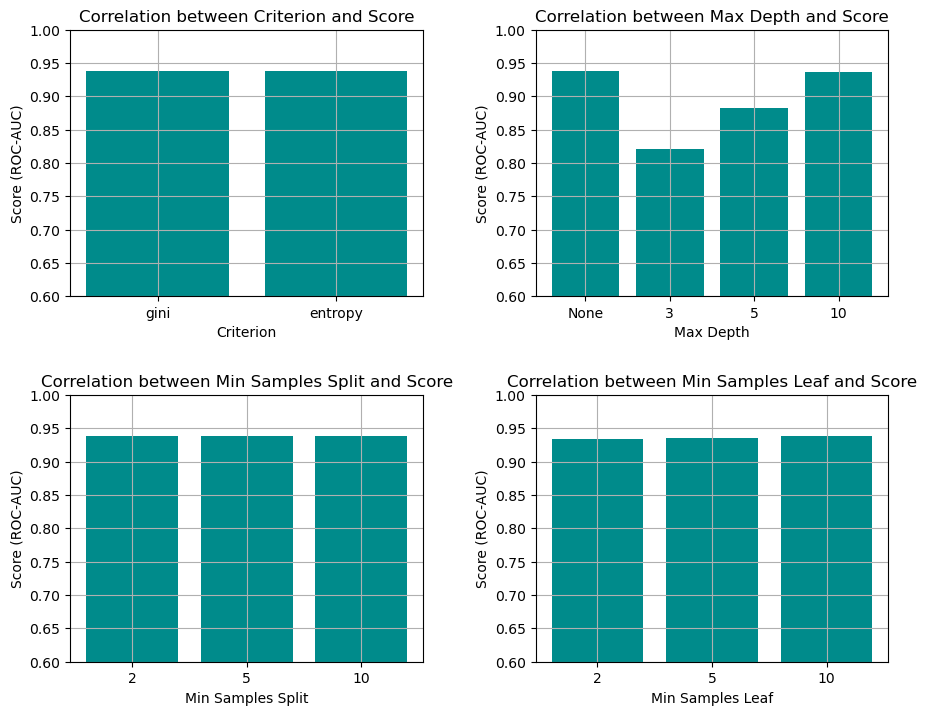

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 5}
ROC-AUC Score: 0.9384941767971616


In [65]:
dt = apply_dt(X_train,y_train)

כל גרף מייצג את הקשר בין ערך של ההיפר-פרמטר לבין הציון ROC_AUC
כאשר בכל גרף ניתן לראות כי נבחר הערך בעל הציון הגבוה ביותר

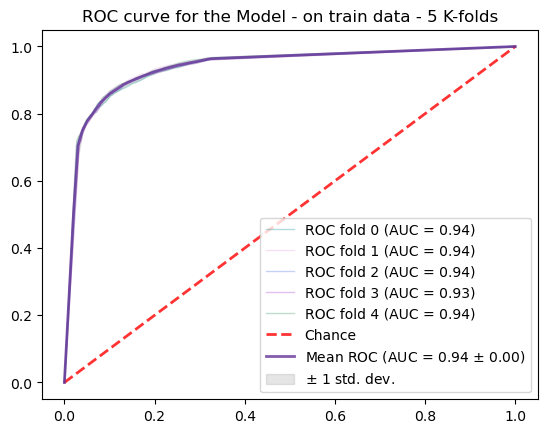

Mean of train Cross-Validation Score: 0.9376319430077642


In [66]:
model_train_scores(X_train,y_train,dt,5)

In [67]:
roc_auc_score_valdiation(dt,X_val,y_val)

The roc_auc_score of DecisionTreeClassifier model on the validation set is: 0.88


ניתן לראות שמודל זה חזה נכון 94% מהדאטה שמוגדר כזדוני של האימון.
בנוסף המודל חזה נכון 88% מהדאטה שמוגדר כזדוני של הולידציה.

אמנם הפער בביצועים של המודל בין האימון לולידציה לא גדול אבל יכול להיות שהפער נובע מהסיבות הבאות:
1. ייתכן והמודל מאומן יתר על המידה על הדאטה של האימון.

2. עבור 3 מתוך 4 מההיפר פרמטרים נבחרו ערכים שעלולים להוביל לoverfitting:
    - criterion - entorpy יכול להוביל לעץ החלטה בעל שונות וגמישות גבוהה יותר מאשר הקריטריון השני
    - max depth - None (ללא הגבלת עומק), ככל שהעץ עמוק יותר כך עולה השונות
    - min samples split - 2 ככל שהמספר קטן יותר כך עולה השונות 

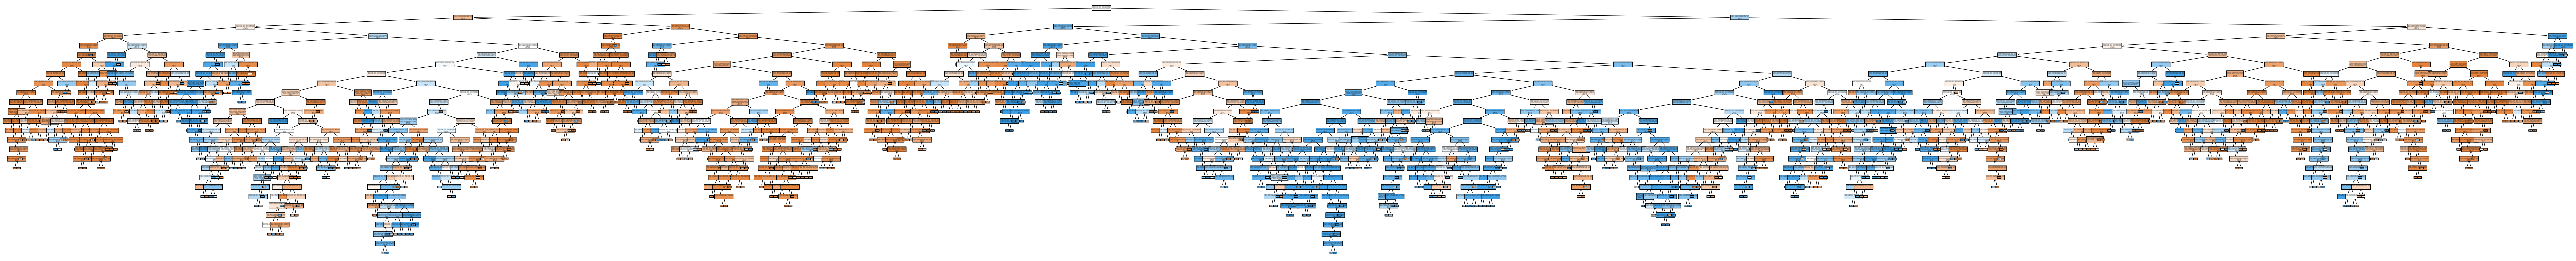

In [68]:
plt.figure(figsize=(100,10))


dot_data  = plot_tree(dt, 
                    feature_names = X_train,
                    class_names = ["0","1"],
                    rounded = True, proportion = False, impurity = True,
                    label='all', precision = 2, filled = True) 


### Random Forest 

תחילת נבדוק מה ההיפר-פרמטרים שמביאים לביצועים הכי טובים של המודל:

1. criterion - 
gini - מודד את ההסתברות שמודל ייתן את הסיווג הלא נכון לתצפית.
שיטה זו אפקטיבית לדאטה סט עם שונות נמוכה.


    entropy - מודד את הכמות הממוצעת של מידע שנדרשת כדי לתת סיווג נכון לתצפית.

בהשוואה בין שני הקריטריונים:
- entropy יכול להוביל לעץ החלטה בעל bias נמוך יותר
- entropy יכול להוביל לעץ החלטה בעל גמישות ושונות גבוהה יותר

2. n estimators -  מתייחס למספר העצים ביער. ככל שהוא גבוה יותר הbias קטן והשונות גדלה.
ככל שמספר זה גבוה יותר אז ניתן לייצג יותר תבניות וקשרים בדאטה.

2. max depth - ככל שהעץ עמוק יותר הגמישות והשונות של המודל על הדאטה עולה (כל פיצול מוסיף לגמישות/שונות) מה שיכול ליצור overfitting.
בנוסף, ככל שהעץ עמוק יותר, הbias יורד

3. min samples split - ככל שהמספר גבוה יותר הדבר יכול למנוע מפיצולים מוקדמים מדי בעץ - כלומר ככל שהמספר גבוה יותר השונות קטנה וקטן הסיכוי לoverfitting.
בהתאם, מספר גבוה יותר של פרמטר זה גורם לעלייה של הbias. החסרון בכך הוא שפיצולים חשובים בעץ עלולים להתפספס

4. min samples leaf - ככל שהמספר גבוה יותר, השונות תיקטן(פחות יחס לתצפיות חריגות בדאטה)  וקטן הסיכוי לoverfitting
בהתאמה, מספר גבוה של פרמטר זה יגרום לbias גבוה.

* n jobs - על לשפר את זמן הריצה, שינינו את ערך ברירת המחדל של פרמטר זה ל10


In [90]:
def hyperparams_randomforest(X,y):
    # Define the parameter grid
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'n_estimators': [20,50], 
        'max_depth': [5, 10,20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5,10]}
        

    #Grid Search Cross-Validation
    grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, scoring='roc_auc', cv=5, n_jobs=10)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X, y)
    
    results = grid_search.cv_results_
    param_n_estimators = results['param_n_estimators']
    param_criterion = results['param_criterion']
    param_max_depth = results['param_max_depth']
    param_min_samples_split = results['param_min_samples_split']
    param_min_samples_leaf = results['param_min_samples_leaf']
    scores = results['mean_test_score']

    # Convert hyperparameter values to strings
    param_n_estimators = [str(d) for d in param_n_estimators]
    param_criterion = [str(c) for c in param_criterion]
    param_max_depth = [str(d) if d else 'None' for d in param_max_depth]
    param_min_samples_split = [str(s) for s in param_min_samples_split]
    param_min_samples_leaf = [str(s) for s in param_min_samples_leaf]

    # Plot the correlation between each hyperparameter and the score
    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    fig.tight_layout(pad=5.0)

    axes[0, 0].bar(param_criterion, scores)
    axes[0, 0].set_xlabel('Criterion')
    axes[0, 0].set_ylabel('Score (ROC-AUC)')
    axes[0, 0].set_title('Correlation between Criterion and Score')
    axes[0, 0].grid(True)
    axes[0, 0].set_ylim([0.9, 1.0]) 

    axes[0, 1].bar(param_max_depth, scores)
    axes[0, 1].set_xlabel('Max Depth')
    axes[0, 1].set_ylabel('Score (ROC-AUC)')
    axes[0, 1].set_title('Correlation between Max Depth and Score')
    axes[0, 1].grid(True)
    axes[0, 1].set_ylim([0.9, 1.0]) 

    axes[1, 0].bar(param_min_samples_split, scores)
    axes[1, 0].set_xlabel('Min Samples Split')
    axes[1, 0].set_ylabel('Score (ROC-AUC)')
    axes[1, 0].set_title('Correlation between Min Samples Split and Score')
    axes[1, 0].grid(True)
    axes[1, 0].set_ylim([0.9, 1.0]) 

    axes[1, 1].bar(param_min_samples_leaf, scores)
    axes[1, 1].set_xlabel('Min Samples Leaf')
    axes[1, 1].set_ylabel('Score (ROC-AUC)')
    axes[1, 1].set_title('Correlation between Min Samples Leaf and Score')
    axes[1, 1].grid(True)
    axes[1, 1].set_ylim([0.9, 1.0]) 

    axes[2, 1].bar(param_n_estimators, scores)
    axes[2, 1].set_xlabel('n_estimators')
    axes[2, 1].set_ylabel('Score (ROC-AUC)')
    axes[2, 1].set_title('Correlation between nestimators and Score')
    axes[2, 1].grid(True)
    axes[2, 1].set_ylim([0.9, 1.0])
    
    plt.show()

    #Select Best Hyperparameters
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_


    print("Best Hyperparameters:", best_params)
    print("ROC-AUC Score:", best_score)
    return best_params


נריץ את המודל עם ההיפר פרמטרים המיטבים ביותר

In [91]:
def apply_rfc(X,y):
    best_params = hyperparams_randomforest(X,y)
    rfc = RandomForestClassifier(random_state=0, criterion=best_params['criterion'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'])
    rfc.fit(X,y)
    return rfc


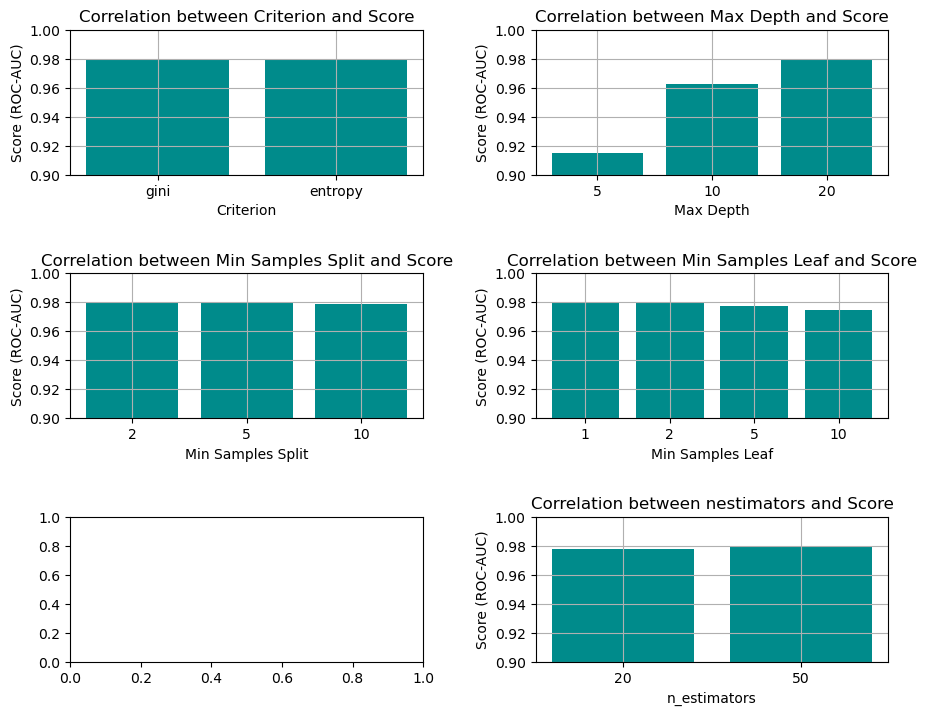

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
ROC-AUC Score: 0.9798924388888889


In [92]:
rfc = apply_rfc(X_train,y_train)

כל גרף מייצג את הקשר בין ערך של ההיפר-פרמטר לבין הציון ROC_AUC
כאשר בכל גרף ניתן לראות כי נבחר הערך בעל הציון הגבוה ביותר

KeyError: "None of [Int64Index([11834, 11837, 11839, 11840, 11841, 11842, 11844, 11846, 11847,\n            11849,\n            ...\n            59990, 59991, 59992, 59993, 59994, 59995, 59996, 59997, 59998,\n            59999],\n           dtype='int64', length=48000)] are in the [columns]"

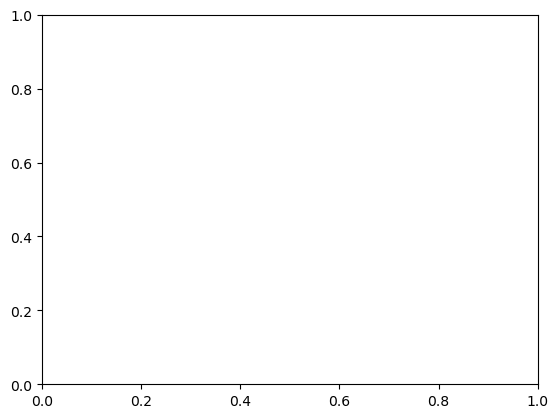

In [93]:
model_train_scores(X_train,y_train,rfc,5)

In [ ]:
roc_auc_score_valdiation(rfc,X_val,y_val)

The roc_auc_score of RandomForestClassifier model on the validation set is: 0.92


ניתן לראות שמודל זה מסביר 98% מהדאטה של האימון.
בנוסף המודל מסביר 92% מהדאטה של הולידציה.

אמנם הפער בביצועים של המודל בין האימון לולידציה לא גדול אבל יכול להיות שהפער נובע מהסיבות הבאות:
1. ייתכן והמודל מאומן יתר על המידה על הדאטה של האימון.

2. עבור 4 מתוך 5 מההיפר פרמטרים נבחרו ערכים שעלולים להוביל לoverfitting:
    - criterion - entorpy יכול להוביל לעץ החלטה בעל שונות וגמישות גבוהה יותר מאשר הקריטריון השני
    - max depth - 20 (העומק הגבוה ביותר שניתן בהיפר פרמטרים), ככל שהעץ עמוק יותר כך עולה השונות
    - min samples split - 2 ככל שהמספר קטן יותר כך עולה השונות 
    - n estimators - 50 - ככל שערכו עולה, המורכבות של היער עולה ולכן גם השונות

3. עבור מודל זה, ככל שיש יותר תצפיות כך היכולת סיווג שלו עולה. דבר זה יכול להסביר את הפער בין הביצועים על נתוני האימון לעומת הביצועים בסט הולידציה (בסט האימון הרבה יותר תצפיות מסט הולדיציה).

ValueError: shape mismatch: objects cannot be broadcast to a single shape

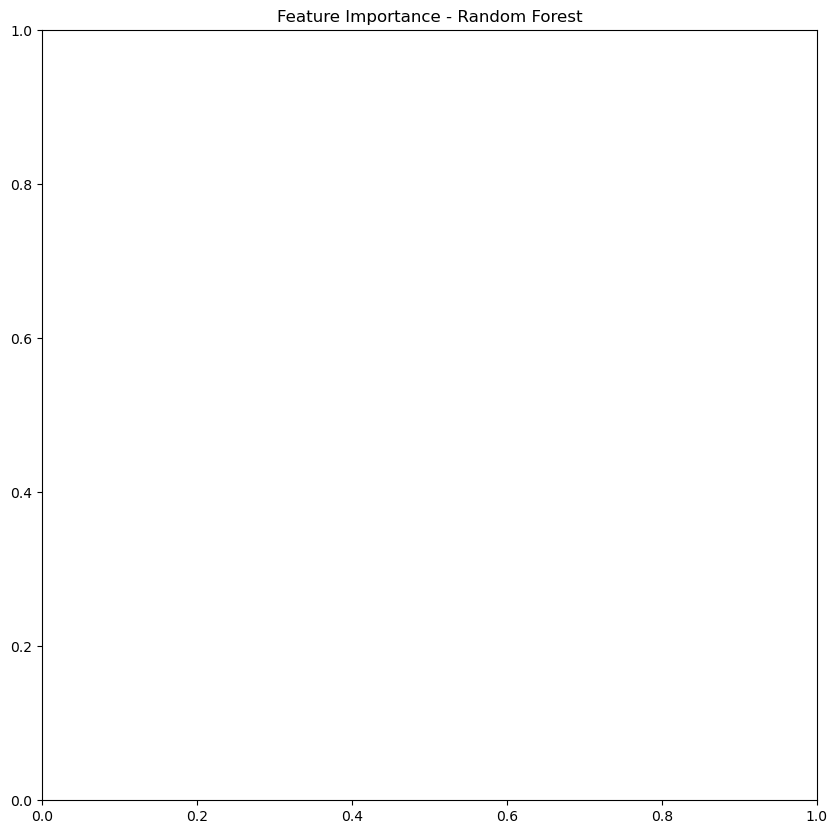

In [ ]:

# Get the feature's importance
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_forward_reduced_df.columns

# Calculate the cumulative importance percentage
cumulative_importance = np.cumsum(importances[indices])
percentage_importance = cumulative_importance / np.sum(importances)

# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.title('Feature Importance - Random Forest')

# Bar plot
bars = plt.bar(range(X_train.shape[1]), importances[indices],
               color="r", align="center")

# Add the feature importance percentage inside each bar
for bar, percentage in zip(bars, percentage_importance):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage*100:.2f}%',
             ha='center', va='bottom', rotation=90)

plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

מהתרשים ניתן לראות כי הפיצ'רים שמשפיעים במידה הגבוהה ביותר על החיזוי (תרומתם גדולה מ-5%) הינם -
1. log_avlength
2. B
3. Imports
4. log imports
5. file type prob trid
6. log urls
7. size

### XGBoost

XGBoost is a machine learning algorithm that uses an ensemble of decision trees and gradient boosting to make predictions.

We chose to examine this model on our data for several reasons:
1. The other models above doesn't use gradiant boosting method for reducing the error of the model.
2. There are several models that use gradiant boosting method, and XGBoost is considered to be the faster, most accurate and most efficient compared to the other gradiant boosting implementations.
3. The default base_estimator of XGBoost is based on decision trees, which make sense to us since RandomForest model (that is also based on decision trees) gave us the best ROC-AUC score (on the validation data) until now.
4. It is suitable for large datasets.
5. Xgboost provides a better understanding of which veriables are most important in making prediction (feature importance)
6. XGBoost supports classification problem.


How does it work:

In a nutshell, it sequentially trains weak models (typically decision trees) to correct the mistake of previous models, which enevtually create a strong predictive model (by combining all the weak models).

In this algorithm, weights are assigned to all the independent veriables, which build the decision tree, that predicts results. The weight of the variables predicted wrong by the tree is increased and these veriables are entered to the next decision tree.
when model gets to the stop condition, all of these individual predictors then combined to one strong and precise model.

תחילת נבדוק מה ההיפר-פרמטרים שמביאים לביצועים הכי טובים של המודל

1. base_estimator - decision trees (default)

2. max depth - ככל שהעץ עמוק יותר הגמישות והשונות של המודל על הדאטה עולה (כל פיצול מוסיף לגמישות/שונות) מה שיכול ליצור overfitting.
בנוסף, ככל שהעץ עמוק יותר, הbias יורד

2. learning rate - קובע את גודל הצעד בכל איטרציה
ככל שהוא נמוך יותר המודל נותן פחות השפעה לכל עץ - מה שיכול להפחית את השונות ולהפחית את הסיכוי לoverfitting.
בהתאמה, ככל שפרמטר זה נמוך יותר, הbias עולה.

3. n_estimators - ככל שערך זה גבוה יותר המודל יכול לעבוד על תבניות מורכבות יותר בסט הנתונים שלנו. בהתאם השונות יכולה לעלות מה שיכול לגרום לoverfitting.
בנוסף, ככל שערך זה גבוה יותר ה-bias פוחת.

4. gamma - משמש כמו רגולריצזיה ששולטת במורכבות של המודל.
ככל שיותר גבוה, השונות קטנה וכך גם הסיכוי לoverfitting.

5. subsample - מתייחס לבחירה רנדומלית של כמות הדאטה עבור כל עץ. ככל שמספר זה גבוה יותר השונות קטנה.
אבל הbias גדל - כי המודל מתאמן על סט נתונים קטן.

In [75]:
def hyperparams_xgboost(X,y):
    # Define the parameter grid
    param_grid = {
        'max_depth': [10,20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [20,50],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.5,1]
    }
        

    # Create the GridSearchCV object
    grid_search = GridSearchCV(XGBClassifier(), param_grid, scoring='roc_auc', cv=5, n_jobs=10)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X, y)

    results = grid_search.cv_results_
    param_n_estimators = results['param_n_estimators']
    param_gamma = results['param_gamma']
    param_max_depth = results['param_max_depth']
    param_subsample = results['param_subsample']
    param_learning_rate = results['param_learning_rate']
    scores = results['mean_test_score']

    # Convert hyperparameter values to strings
    param_n_estimators = [str(d) for d in param_n_estimators]
    param_gamma = [str(c) for c in param_gamma]
    param_max_depth = [str(d) if d else 'None' for d in param_max_depth]
    param_subsample = [str(s) for s in param_subsample]
    param_learning_rate = [str(s) for s in param_learning_rate]

    # Plot the correlation between each hyperparameter and the score
    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    fig.tight_layout(pad=5.0)

    axes[0, 0].bar(param_n_estimators, scores)
    axes[0, 0].set_xlabel('param_n_estimators')
    axes[0, 0].set_ylabel('Score (ROC-AUC)')
    axes[0, 0].set_title('Correlation between param_n_estimators and Score')
    axes[0, 0].grid(True)
    axes[0, 0].set_ylim([0.9, 1.0]) 

    axes[0, 1].bar(param_max_depth, scores)
    axes[0, 1].set_xlabel('Max Depth')
    axes[0, 1].set_ylabel('Score (ROC-AUC)')
    axes[0, 1].set_title('Correlation between Max Depth and Score')
    axes[0, 1].grid(True)
    axes[0, 1].set_ylim([0.9, 1.0]) 

    axes[1, 0].bar(param_gamma, scores)
    axes[1, 0].set_xlabel('param_gamma')
    axes[1, 0].set_ylabel('Score (ROC-AUC)')
    axes[1, 0].set_title('Correlation between param_gamma and Score')
    axes[1, 0].grid(True)
    axes[1, 0].set_ylim([0.9, 1.0]) 

    axes[1, 1].bar(param_subsample, scores)
    axes[1, 1].set_xlabel('param_subsample')
    axes[1, 1].set_ylabel('Score (ROC-AUC)')
    axes[1, 1].set_title('Correlation between param_subsample and Score')
    axes[1, 1].grid(True)
    axes[1, 1].set_ylim([0.9, 1.0]) 

    axes[2, 0].bar(param_learning_rate, scores)
    axes[2, 0].set_xlabel('param_learning_rate')
    axes[2, 0].set_ylabel('Score (ROC-AUC)')
    axes[2, 0].set_title('Correlation between param_learning_rate and Score')
    axes[2, 0].grid(True)
    axes[2, 0].set_ylim([0.9, 1.0])
    
    plt.show()

    #Select Best Hyperparameters
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_


    print("Best Hyperparameters:", best_params)
    print("ROC-AUC Score:", best_score)
    return best_params

נריץ את המודל עם ההיפר פרמטרים המיטבים ביותר

In [76]:
def apply_xgb(X,y):
    best_params = hyperparams_xgboost(X,y)
    xgbclassifier = XGBClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'])
    xgbclassifier.fit(X,y)
    return xgbclassifier


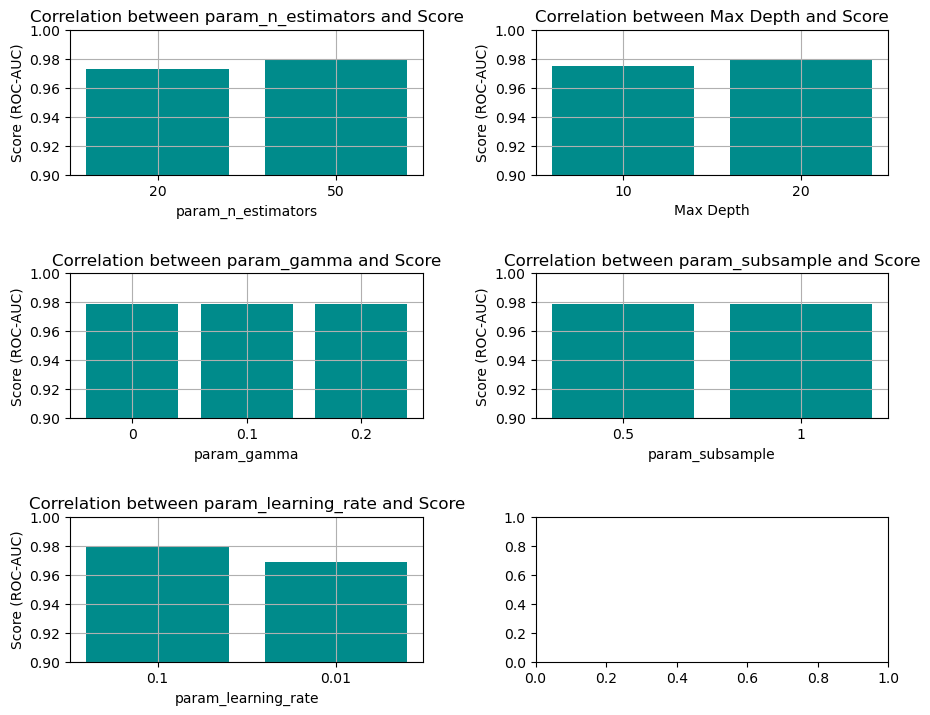

Best Hyperparameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 50, 'subsample': 0.5}
ROC-AUC Score: 0.978968395961876


In [77]:
xgbclassifier = apply_xgb(X_train,y_train)

כל גרף מייצג את הקשר בין ערך של ההיפר-פרמטר לבין הציון ROC_AUC
כאשר בכל גרף ניתן לראות כי נבחר הערך בעל הציון הגבוה ביותר

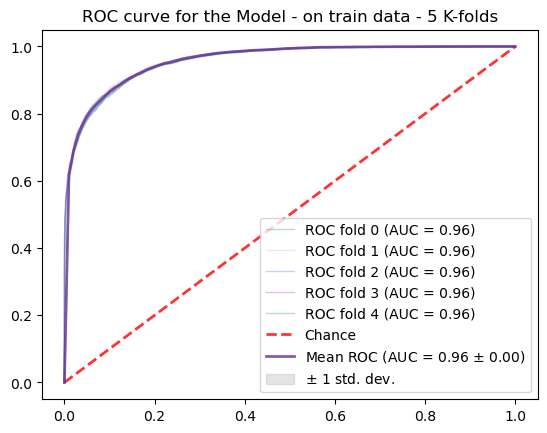

Mean of train Cross-Validation Score: 0.9588258692359043


In [78]:
model_train_scores(X_train,y_train,xgbclassifier,5)

In [79]:
roc_auc_score_valdiation(xgbclassifier,X_val,y_val)

The roc_auc_score of XGBClassifier model on the validation set is: 0.88


ניתן לראות שמודל זה מסביר 96% מהדאטה של האימון.
בנוסף המודל מסביר 88% מהדאטה של הולידציה.

אמנם הפער בביצועים של המודל בין האימון לולידציה לא גדול אבל יכול להיות שהפער נובע מהסיבות הבאות:
1. ייתכן והמודל מאומן יתר על המידה על הדאטה של האימון.

2. עבור 4 מתוך 5 מההיפר פרמטרים נבחרו ערכים שעלולים להוביל לoverfitting:
    - learning rate - ככל שגדול יותר השונות עולה (נבחר הערך הגבוה ביותר)
    - max depth- ככל שהמספר גדול יותר השונות עולה (נבחר הערך הגבוה ביותר)
    - n estimators - 50 - ככל שערכו עולה, המורכבות של היער עולה ולכן גם השונות
    - subsample - ככל שמספר זה קטן יותר השונות גדלה

3. עבור מודל זה, ככל שיש יותר תצפיות כך היכולת סיווג שלו עולה. דבר זה יכול להסביר את הפער בין הביצועים על נתוני האימון לעומת הביצועים בסט הולידציה (בסט האימון הרבה יותר תצפיות מסט הולדיציה).

In [80]:
def plot_roc_curve(models, X, y):
    plt.figure(figsize=(8, 6))
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    for model in models.keys():
        # Get predicted probabilities
        y_pred_proba = model.predict_proba(X)[:, 1]
        # Calculate false positive rate, true positive rate, and threshold
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {models[model]:.2f})')

    # Add legend and grid
    plt.legend(loc='lower right')
    plt.grid(True)

    # Show the plot
    plt.show()


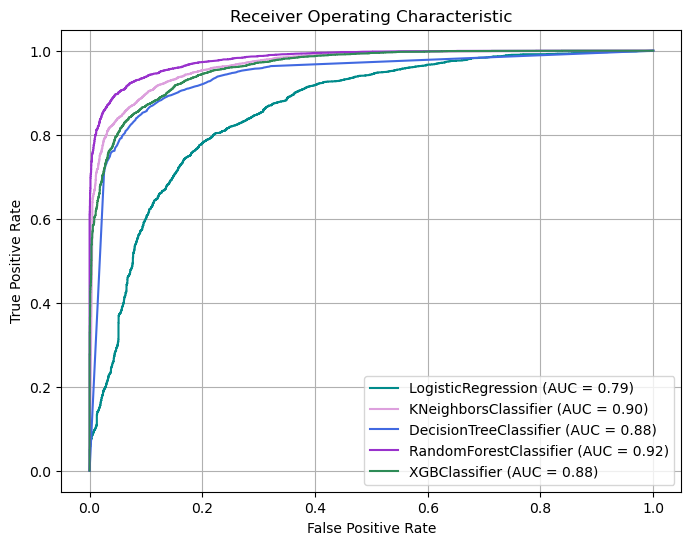

In [81]:
plot_roc_curve(models, X_val, y_val)

בחרנו להשתמש בRandom Forest בתור המודל הסופי שלנו.

לפי הגרף הנ"ל, ניתן לראות שהמודל הנבחר קיבל את הציון הגבוה ביותר עבור ניבוי המודל על סט הולידציה. 
בנוסף, עבור מודל זה התקבל הפער הנמוך ביותר בציון בביצוע בין סט האימון לבין סט הולידציה

In [82]:
# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = (end_time - start_time)/60

# Print the elapsed time
print("Elapsed time:", elapsed_time, "minutes")

Elapsed time: 40.36884838740031 minutes


# Pipline for Final Prediction

### Train Preprocessing + Model


X.shape: (60000, 39)


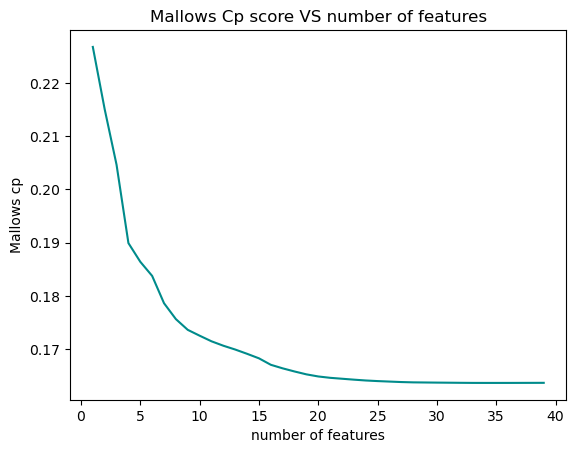

Number of Chosen Features: 35
Chosen features: ['size', 'vsize', 'imports', 'exports', 'has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls', 'paths', 'urls', 'MZ', 'printables', 'file_type_prob_trid', 'B', 'log_vsize', 'log_imports', 'log_exports', 'log_numstrings', 'log_avlength', 'log_printables', 'log_paths', 'log_urls', 'log_registry', 'log_MZ', 'category_DOS Executable Generic', 'category_Generic CIL Executable (.NET, Mono, etc.)', 'category_InstallShield setup', 'category_UPX compressed Win32 Executable', 'category_Win32 Dynamic Link Library (generic)', 'category_Win32 Executable (generic)', 'category_Win32 Executable MS Visual C++ (generic)', 'category_Win32 Executable Microsoft Visual Basic 6', 'category_Win64 Executable (generic)', 'category_Windows Control Panel Item (generic)']


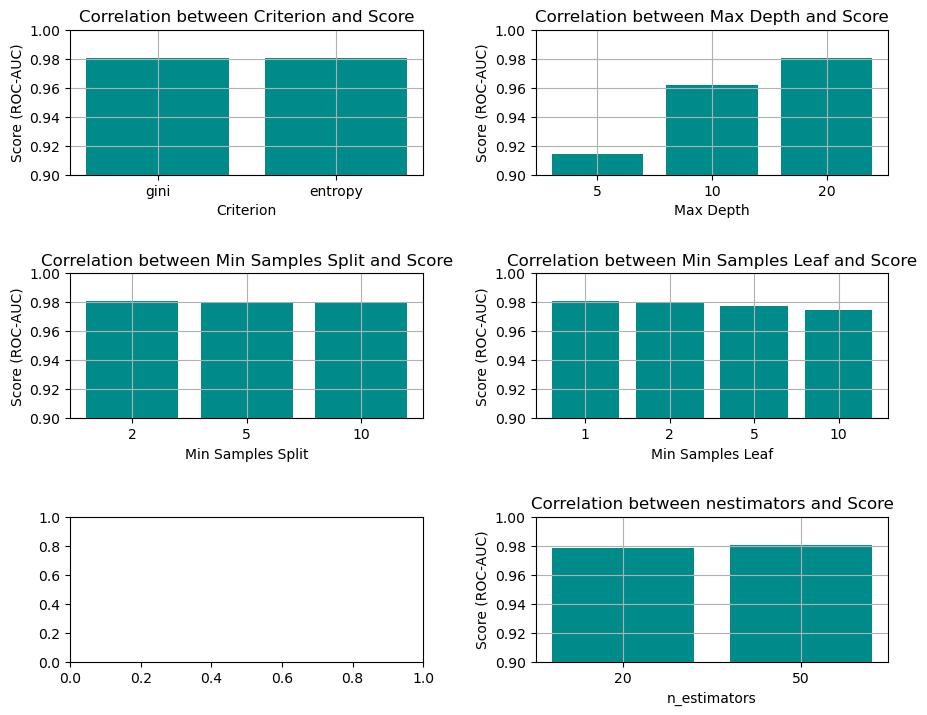

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
ROC-AUC Score: 0.9804762194444445


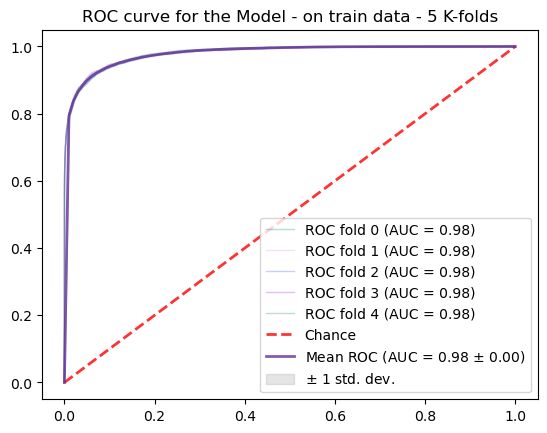

Mean of train Cross-Validation Score: 0.9800494138888889


In [83]:
# import the train data
df_train = pd.read_csv("train.csv", index_col= 0)
#נחלק את הפיצ'רים של הדאטה לפי קטגוריות
feature_list_num, feature_list_binary, feature_list_cat = features_lists()
#נמלא ערכים חסרים עבור פיצ'רים בינאריים
empty_values_binary(df_train,df_train, feature_list_binary)
#נמלא ערכים חסרים עבור פיצ'רים מספריים
empty_values_numeric(df_train,df_train, feature_list_num)
#נוסיף פיצ'רים חדשים
df_train, feature_list_num, log_feature_list = add_feature_logs(df_train, feature_list_num)
#נעשה אגרגרציה לערכים נדירים תחת file type trid 
df_new_train = apply_aggregation(df_train,df_train)
#נפצל את הערכים הקטגורייאלים של file type trid לעמודות
cleaned_df_new_train, encoder = encode_categorical_filetypetrid_train(df_new_train)
#נמחק פיצ'רים
cleaned_df_new_train = delete_features(cleaned_df_new_train)
#נפצל את הדאטה לX,y
X_train,y_train = split_data_x_y(cleaned_df_new_train)
# ננרמל את הדאטה לפי ממוצע 0 ושונות 1
X_norm_train = normalize_data(X_train)
# נריץ מודל להורדת מימדים
selected_features, chosen_features = run_FS(X_train,X_norm_train,y_train)
# ניישם את הפיצ'רים הנבחרים על הדאטה שלנו
X_train_forward_reduced  = apply_fs_on_data(X_norm_train)
# נמחק פיצ'רים
cleaned_df_new_train = delete_features2(cleaned_df_new_train)
# נבחר את ההיפר פרמטרים הטובים ביותר עבור המודל הנבחר שלנו random forest
rfc_best_params = apply_rfc(X_train_forward_reduced,y_train)
# נחשב את הציון עבור ביצועי המודל עבור ההיפר פרמטרים שנבחרו
model_train_scores(X_train_forward_reduced,y_train,rfc_best_params,5)

### Test Preprocessing

In [84]:
# import the train data
df_test = pd.read_csv("test.csv", index_col= 0)
#נחלק את הפיצ'רים של הדאטה לפי קטגוריות
feature_list_num, feature_list_binary, feature_list_cat = features_lists()
#נמלא ערכים חסרים עבור פיצ'רים בינאריים
empty_values_binary(df_train, df_test,feature_list_binary)
#נמלא ערכים חסרים עבור פיצ'רים מספריים
empty_values_numeric(df_train, df_test,feature_list_num)
#נוסיף פיצ'רים חדשים
df_test, feature_list_num, log_feature_list = add_feature_logs(df_test, feature_list_num)
#נעשה אגרגרציה לערכים נדירים תחת file type trid - זאת לפי הדאטה של האימון
df_new_test = apply_aggregation(df_train,df_test)
#נפצל את הערכים הקטגורייאלים של file type trid לעמודות
cleaned_df_new_test = encode_categorical_filetypetrid_test(df_new_test, encoder)
#נמחק פיצ'רים
cleaned_df_new_test = delete_features(cleaned_df_new_test)
cleaned_df_new_test = cleaned_df_new_test.set_index('sha256')
# ננרמל את הדאטה לפי ממוצע 0 ושונות 1
X_norm_test = normalize_data(cleaned_df_new_test)
# ניישם את הפיצ'רים הנבחרים על הדאטה שלנו - לפי הדאטה של האימון
X_forward_reduced_test = apply_fs_on_data(X_norm_test)
#נמחק פיצ'רים
cleaned_df_new_test = delete_features2(cleaned_df_new_test)

X.shape: (18000, 39)


### Test Prediction

In [85]:
# עבור כל תצפית, על סמך המודל וההיפר פרמטרים שנבחרו, נבצע תחזית ונקבל את ההסתברות לקבלת כל אחד מהלייבלים
final_predictions = rfc_best_params.predict_proba(X_forward_reduced_test)

# נתמקד רק בהסתברות שקובץ הוא זדוני
final_predictions_malicious = final_predictions[:,1]

# הוספת עמודה חדשה עם התחזית שקובץ הוא זדוני
df_test['predict_proba'] = final_predictions_malicious

# ייצוא העמודות הרלוונטיות לקובץ אקסל 
final_columns_to_output = ['sha256', 'predict_proba']
selectlist =[x for x in df_test.columns if x in final_columns_to_output]
datatowrite = df_test[selectlist]

datatowrite.to_csv('results_31.csv')